In [44]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import graphviz
import pytorchviz
torch.manual_seed(1)
import IGTD_Functions

warnings.filterwarnings("ignore")

# Importing the combined dataset

In [95]:
data_raw = pd.read_csv('dataset_combined.csv')
data_raw = data_raw.drop('Unnamed: 0', axis=1)  # remove unnamed index column
print(data_raw.info())
data_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29261 entries, 0 to 29260
Data columns (total 12 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   air_pressure(mBar)                              25098 non-null  float64
 1   date                                            29261 non-null  int64  
 2   coordinates                                     28866 non-null  object 
 3   air_temperature                                 26537 non-null  float64
 4   mass_concentration_of_chlorophyll_in_sea_water  889 non-null    float64
 5   relative_humidity                               5482 non-null   float64
 6   mass_concentration_of_oxygen_in_sea_wate        2928 non-null   float64
 7   sea_water_practical_salinity                    8096 non-null   float64
 8   USA_SSHS                                        28 non-null     float64
 9   xco2                                   

air_pressure(mBar)      date coordinates  air_temperature  \
0             9999.00  20150601   29.0-92.0             28.9   
1             1015.20  20150601   28.0-92.0             28.9   
2             1015.90  20150601   29.0-88.0             26.7   
3             1015.98  20150601   28.0-94.0             11.0   
4             1015.70  20150601   30.0-87.0             25.8   

   mass_concentration_of_chlorophyll_in_sea_water  relative_humidity  \
0                                             NaN                NaN   
1                                             NaN                NaN   
2                                             NaN                NaN   
3                                             NaN               49.9   
4                                             NaN                NaN   

   mass_concentration_of_oxygen_in_sea_wate  sea_water_practical_salinity  \
0                                       NaN                           NaN   
1                                       NaN                           NaN   
2                                       NaN                           NaN   
3                                       NaN                         35.24   
4                                       NaN                           NaN   

   USA_SSHS  xco2  Methane_ppbv  tropical_storm_occurence  
0       NaN   NaN        1850.0                       0.0  
1       NaN   NaN        1850.0                       0.0  
2       NaN   NaN        1850.0                       0.0  
3       NaN   NaN        1850.0                       0.0  
4       NaN   NaN        1850.0                       0.0

# data preprocessing

In [96]:
print('Cholorophyll data',data_raw['mass_concentration_of_chlorophyll_in_sea_water'].isna().sum()/len(data_raw))
print('As more than 96% of the chlorophyll input is na, remove the column')
print('')
print('Salinity data',data_raw['sea_water_practical_salinity'].isna().sum()/len(data_raw))
print('As more than 71% of the salinity input is na, remove the column')
print('')
print('Oxygen data',data_raw['mass_concentration_of_oxygen_in_sea_wate'].isna().sum()/len(data_raw))
print('As more than 90% of the oxygen input is na, remove the column')
print('')
print('Humidity data',data_raw['relative_humidity'].isna().sum()/len(data_raw))
print('As more than 81% of the humidity input is na, remove the column')
print('')
print('Air Temperature data',data_raw['air_temperature'].isna().sum()/len(data_raw))
print('As less than 9% of the Air Temperature input is na, keep the column')
print('')
print('Air_pressure(mBar) data',data_raw['air_pressure(mBar)'].isna().sum()/len(data_raw))
print('As less than 14% of the air_pressure(mBar) input is na, keep the column')
print('')
print('date data',data_raw['date'].isna().sum()/len(data_raw))
print('As no date input is na, keep the column')
print('')
print('coordinates data',data_raw['coordinates'].isna().sum()/len(data_raw))
print('As no coordinates input is na, keep the column')
print('')
print('tropical_storm_occurence data',data_raw['tropical_storm_occurence'].isna().sum()/len(data_raw))
print('As no tropical_storm_occurence input is na, keep the column')
print('')
print('Methane_ppbv data',data_raw['Methane_ppbv'].isna().sum()/len(data_raw))
print('Methane_ppbv input is 99% na, keep the column')
print('')
print('tropical_storm_occurence data',data_raw['tropical_storm_occurence'].isna().sum()/len(data_raw))
print('average_Methane_ppb input is 0% na, keep the column')
print('')
print('USA_SSHS data',data_raw['USA_SSHS'].isna().sum()/len(data_raw))
print('USA_SSHS input is 99% na, keep the column')
print('')
print('xco2 data',data_raw['xco2'].isna().sum()/len(data_raw))
print('xco2 input is 91% na, keep the column')
print('')
print('Methane/CO2 are global/average values. Input average of each day for CO2/month for methane to fill columns.')

Cholorophyll data 0.9696182632172516
As more than 96% of the chlorophyll input is na, remove the column

Salinity data 0.7233177266668945
As more than 71% of the salinity input is na, remove the column

Oxygen data 0.8999350671542325
As more than 90% of the oxygen input is na, remove the column

Humidity data 0.8126516523700489
As more than 81% of the humidity input is na, remove the column

Air Temperature data 0.09309319572126722
As less than 9% of the Air Temperature input is na, keep the column

Air_pressure(mBar) data 0.14227128259457983
As less than 14% of the air_pressure(mBar) input is na, keep the column

date data 0.0
As no date input is na, keep the column

coordinates data 0.013499196883223404
As no coordinates input is na, keep the column

tropical_storm_occurence data 0.0
As no tropical_storm_occurence input is na, keep the column

Methane_ppbv data 0.5801578893407607
Methane_ppbv input is 99% na, keep the column

tropical_storm_occurence data 0.0
average_Methane_ppb inpu

In [97]:
# We are therefore left with:
data = data_raw[['air_pressure(mBar)','date','coordinates','air_temperature','USA_SSHS','xco2','Methane_ppbv','tropical_storm_occurence']]
data.head(3)

air_pressure(mBar)      date coordinates  air_temperature  USA_SSHS  xco2  \
0              9999.0  20150601   29.0-92.0             28.9       NaN   NaN   
1              1015.2  20150601   28.0-92.0             28.9       NaN   NaN   
2              1015.9  20150601   29.0-88.0             26.7       NaN   NaN   

   Methane_ppbv  tropical_storm_occurence  
0        1850.0                       0.0  
1        1850.0                       0.0  
2        1850.0                       0.0

In [98]:
# Filling in average_Methane_ppb as new rows were created to add these datasets
data['year'] = data['date'].floordiv(10000) # remove the days from the month
data['methane'] = data['Methane_ppbv'] # get new methane column in order to remove later
print(data['Methane_ppbv'].isna().sum())
# for each of same month make all the nan = the value for that month
data['Methane_ppbv'] = data.groupby(['year'], sort=False)['Methane_ppbv'].apply(lambda x: x.ffill().bfill())

data = data[~data['methane'].notna()] # remove rows where methane is not NaN
data = data.drop(columns = ['year','methane']) # drop year and methane
print(data['Methane_ppbv'].isna().sum())
data.head(3)

16976
87


air_pressure(mBar)      date coordinates  air_temperature  USA_SSHS  xco2  \
24              9999.0  20150602   29.0-92.0             30.1       NaN   NaN   
25              1013.5  20150602   28.0-92.0             28.9       NaN   NaN   
26              1012.9  20150602   29.0-88.0             26.7       NaN   NaN   

    Methane_ppbv  tropical_storm_occurence  
24        1850.0                       0.0  
25        1850.0                       0.0  
26        1850.0                       0.0

In [99]:
# Filling in xco2
data['CO2'] = data['xco2'] # get new methane column in order to remove later
print(data['xco2'].isna().sum()/len(data))

# for each of same day make all the nan = the value for that day, this reduced based on days, but CO2 input is not everyday
data['xco2'] = data.groupby(['date'], sort=False)['xco2'].apply(lambda x: x.ffill().bfill())
print(data['xco2'].isna().sum()/len(data))

# for missing days, make the same for the days after.
data['yearmonth'] = data['date'].floordiv(100) # remove the days from the month
data['xco2'] = data.groupby(['yearmonth'], sort=False)['xco2'].apply(lambda x: x.ffill().bfill())
print(data['xco2'].isna().sum()/len(data))

# for the remaining empty CO2 columns, use fill method from previous values.
data['xco2'] = data['xco2'].ffill()
data = data[~data['CO2'].notna()] # remove rows where CO2 is original not NaN
data = data.drop(columns = ['CO2','yearmonth']) # drop year and methane
print(data['xco2'].isna().sum()/len(data))
data.head(3)

0.9229500471253534
0.6954524033930255
0.03222196041470311
0.0


air_pressure(mBar)      date coordinates  air_temperature  USA_SSHS  \
24              9999.0  20150602   29.0-92.0             30.1       NaN   
25              1013.5  20150602   28.0-92.0             28.9       NaN   
26              1012.9  20150602   29.0-88.0             26.7       NaN   

          xco2  Methane_ppbv  tropical_storm_occurence  
24  398.389282        1850.0                       0.0  
25  398.389282        1850.0                       0.0  
26  398.389282        1850.0                       0.0

In [100]:
# for air pressure and air_temperature
print(data['air_pressure(mBar)'].isna().sum()/len(data))
# for the remaining empty air_pressure columns, use fill method from previous values.
data['air_pressure(mBar)'] = data['air_pressure(mBar)'].ffill()
# for the remaining empty air_temperature columns, use fill method from previous values.
data['air_temperature'] = data['air_temperature'].ffill()

print(data['air_pressure(mBar)'].isna().sum()/len(data))
print(data['air_temperature'].isna().sum()/len(data))

0.06912177687005361
0.0
0.0


In [101]:
# Filling in USA_SSHS
print('Unique values: ', data['USA_SSHS'].unique())
data['USA_SSHS'] = data['USA_SSHS'] + 5
print('Unique values: ', data['USA_SSHS'].unique())
# Fill NaN with -99, a value not used in the column as these will indicate no chance of hurricane
data['USA_SSHS'] = data['USA_SSHS'].fillna(0)
print('Unique values: ', data['USA_SSHS'].unique())
data.head(3)

Unique values:  [nan  0. -1. -3. -4.  3.]
Unique values:  [nan  5.  4.  2.  1.  8.]
Unique values:  [0. 5. 4. 2. 1. 8.]


air_pressure(mBar)      date coordinates  air_temperature  USA_SSHS  \
24              9999.0  20150602   29.0-92.0             30.1       0.0   
25              1013.5  20150602   28.0-92.0             28.9       0.0   
26              1012.9  20150602   29.0-88.0             26.7       0.0   

          xco2  Methane_ppbv  tropical_storm_occurence  
24  398.389282        1850.0                       0.0  
25  398.389282        1850.0                       0.0  
26  398.389282        1850.0                       0.0

# data exploration

In [102]:
data

air_pressure(mBar)      date coordinates  air_temperature  USA_SSHS  \
24                9999.00  20150602   29.0-92.0            30.10       0.0   
25                1013.50  20150602   28.0-92.0            28.90       0.0   
26                1012.90  20150602   29.0-88.0            26.70       0.0   
27                1014.01  20150602   28.0-94.0            10.80       0.0   
28                1014.10  20150602   28.0-95.0            28.00       0.0   
...                   ...       ...         ...              ...       ...   
27702             1021.20  20211129   29.0-97.0            15.90       0.0   
27703             1020.40  20211129   29.0-95.0            17.40       0.0   
27704             1022.00  20211129   30.0-88.0             9.50       0.0   
27724             1022.01  20211131   30.0-88.0            13.58       0.0   
27725             1022.01  20200724   27.0-93.0            13.58       5.0   

             xco2  Methane_ppbv  tropical_storm_occurence  
24     398.389282   1850.000000                       0.0  
25     398.389282   1850.000000                       0.0  
26     398.389282   1850.000000                       0.0  
27     398.389282   1850.000000                       0.0  
28     398.389282   1850.000000                       0.0  
...           ...           ...                       ...  
27702  415.787170   1911.404597                       0.0  
27703  415.787170   1911.404597                       0.0  
27704  415.787170   1911.404597                       0.0  
27724  415.787170   1909.370453                       0.0  
27725  406.776062   1905.302166                       1.0  

[15668 rows x 8 columns]

In [103]:
data['USA_SSHS'].unique()

array([0., 5., 4., 2., 1., 8.])

<Figure size 1200x800 with 0 Axes>

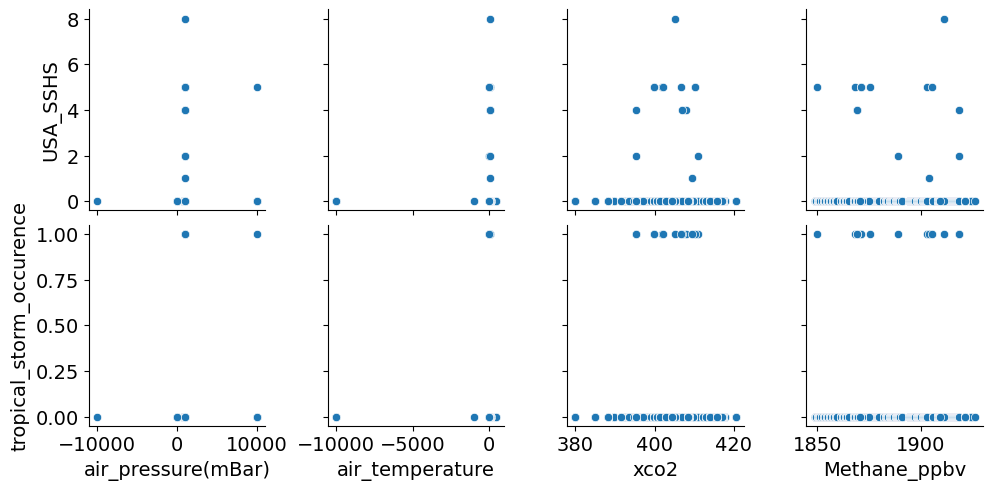

In [104]:
plt.figure(figsize=(15, 10), dpi=80)
plt.rcParams.update({'font.size': 14})
g = sns.pairplot(data, x_vars=["air_pressure(mBar)",'air_temperature','xco2','Methane_ppbv'], 
                 y_vars=["USA_SSHS","tropical_storm_occurence"])
plt.show()

<AxesSubplot:>

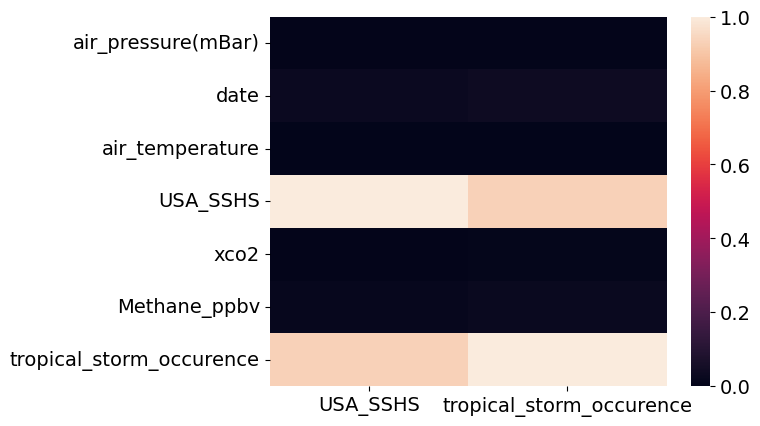

In [14]:
correlation = data.corr()[['USA_SSHS','tropical_storm_occurence']]
sns.heatmap(correlation)

# Building the model

In [105]:
data_code = data.copy()
data_code['year'] = data_code['date'].floordiv(10000) # keep only year
data_code = data_code[data_code['year'] < 2021]
data_code = data_code.drop(columns = ['year']) # year column once filtering is done.
print(len(data_code))

data_unseen = data.copy()
data_unseen['year'] = data_unseen['date'].floordiv(10000) # keep only year
data_unseen = data_unseen[data_unseen['year'] == 2021]
data_unseen = data_unseen.drop(columns = ['year']) # year column once filtering is done.
print(len(data_unseen))
data_unseen.head()

14765
903


air_pressure(mBar)      date coordinates  air_temperature  USA_SSHS  \
24108              1015.1  20210601   28.0-96.0             26.0       0.0   
24109              1017.1  20210601   29.0-90.0             25.9       0.0   
24110              1013.7  20210601   28.0-97.0             27.5       0.0   
24111              1018.6  20210601   30.0-87.0             26.4       0.0   
24112              1017.1  20210601   29.0-89.0             28.8       0.0   

             xco2  Methane_ppbv  tropical_storm_occurence  
24108  417.833832   1908.498677                       0.0  
24109  417.833832   1908.498677                       0.0  
24110  417.833832   1908.498677                       0.0  
24111  417.833832   1908.498677                       0.0  
24112  417.833832   1908.498677                       0.0

In [106]:
# is_a_hit = data_code['tropical_storm_occurence'] == 1
# df_hit = data_code[is_a_hit]
# data_code = data_code.append([df_hit]*1000,ignore_index=True)   # append these rows 1000 times to make it balanced dataset.
# print(len(data_code))
# # then to make the 1's appear throughout the dataframe, randomly sample it
# data_code = data_code.sample(n=len(data_code))

# split coordinates back to latitude longitude to be converted into an array
data_code[['latitude','longitude']] = data_code['coordinates'].str.split('-',expand = True)
data_code = data_code.drop(columns = ['coordinates'])
print(len(data_code))
data_code.head()

14765


air_pressure(mBar)      date  air_temperature  USA_SSHS        xco2  \
24             9999.00  20150602             30.1       0.0  398.389282   
25             1013.50  20150602             28.9       0.0  398.389282   
26             1012.90  20150602             26.7       0.0  398.389282   
27             1014.01  20150602             10.8       0.0  398.389282   
28             1014.10  20150602             28.0       0.0  398.389282   

    Methane_ppbv  tropical_storm_occurence latitude longitude  
24        1850.0                       0.0     29.0      92.0  
25        1850.0                       0.0     28.0      92.0  
26        1850.0                       0.0     29.0      88.0  
27        1850.0                       0.0     28.0      94.0  
28        1850.0                       0.0     28.0      95.0

In [137]:
# split coordinates back to latitude longitude to be converted into an array
data_unseen[['latitude','longitude']] = data_unseen['coordinates'].str.split('-',expand = True)
data_unseen = data_unseen.drop(columns = ['coordinates'])
print(len(data_unseen))
data_unseen.head()

903


air_pressure(mBar)      date  air_temperature  USA_SSHS        xco2  \
24108              1015.1  20210601             26.0       0.0  417.833832   
24109              1017.1  20210601             25.9       0.0  417.833832   
24110              1013.7  20210601             27.5       0.0  417.833832   
24111              1018.6  20210601             26.4       0.0  417.833832   
24112              1017.1  20210601             28.8       0.0  417.833832   

       Methane_ppbv  tropical_storm_occurence latitude longitude  
24108   1908.498677                       0.0     28.0      96.0  
24109   1908.498677                       0.0     29.0      90.0  
24110   1908.498677                       0.0     28.0      97.0  
24111   1908.498677                       0.0     30.0      87.0  
24112   1908.498677                       0.0     29.0      89.0

# Neural networks without picture

## UNet

In [112]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import imblearn
from imblearn.over_sampling import SMOTE

data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()
data_code

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956

X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_nn = data_nn['tropical_storm_occurence'].values
X_nn, Y_nn = SMOTE().fit_resample(X_nn, Y_nn)
data_nn = pd.DataFrame(np.column_stack([X_nn,Y_nn]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_nn = data_nn[['tropical_storm_occurence','USA_SSHS']].values

X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X_nn, Y_nn, test_size = 0.2, random_state = 42) 

X_train_nn = torch.from_numpy(X_train_nn).float()
X_test_nn = torch.from_numpy(X_test_nn).float()
Y_train_nn = torch.from_numpy(Y_train_nn).type(torch.LongTensor).float()
Y_test_nn = torch.from_numpy(Y_test_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
train_nn = TensorDataset(X_train_nn,Y_train_nn)
test_nn = TensorDataset(X_test_nn,Y_test_nn)

# # batch_size, epoch and iteration
batch_size = 64
n_iters = 700
num_epochs = n_iters / (len(X_train_nn) / batch_size)

num_epochs = int(num_epochs)
print("Epoch Number: ",num_epochs)

# data loader
train_loader_nn = DataLoader(train_nn, batch_size = batch_size, shuffle = False, drop_last=True)
test_loader_nn = DataLoader(test_nn, batch_size = batch_size, shuffle = False, drop_last=True)

Epoch Number:  1


In [141]:
data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']].values

X_unseen_nn = torch.from_numpy(X_unseen_nn).float()
Y_unseen_nn = torch.from_numpy(Y_unseen_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
unseen_nn = TensorDataset(X_unseen_nn,Y_unseen_nn)

# data loader
unseen_nn = DataLoader(unseen_nn, batch_size = batch_size, shuffle = False, drop_last=True)

In [113]:
import torch
from torch import nn
import pytorch_lightning as pl

class SoftOrdering1DCNN(pl.LightningModule):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2):
        super().__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        dense1 = nn.Linear(input_dim, hidden_size, bias=False)
        self.dense1 = nn.utils.weight_norm(dense1)

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        conv1 = conv1 = nn.Conv1d(
            cha_input, 
            cha_input*K, 
            kernel_size=5, 
            stride = 1, 
            padding=2,  
            groups=cha_input, 
            bias=False)
        self.conv1 = nn.utils.weight_norm(conv1, dim=None)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input*K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        conv2 = nn.Conv1d(
            cha_input*K, 
            cha_hidden, 
            kernel_size=2, #3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)

        # 3rd conv layer
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_hidden)
        conv3 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv3 = nn.utils.weight_norm(conv3, dim=None)
        

        # 4th conv layer
        self.batch_norm_c4 = nn.BatchNorm1d(cha_hidden)
        conv4 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=5, 
            stride=1, 
            padding=2, 
            groups=cha_hidden, 
            bias=False)
        self.conv4 = nn.utils.weight_norm(conv4, dim=None)

        self.avg_po_c4 = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.batch_norm2 = nn.BatchNorm1d(output_size)
        self.dropout2 = nn.Dropout(dropout_output)
        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        self.loss = nn.BCEWithLogitsLoss()
    

    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = nn.functional.celu(self.dense1(x))
        
        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1)
        
        x = self.batch_norm_c1(x)
        x = nn.functional.relu(self.conv1(x))

        x = self.ave_po_c1(x)
        
        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = nn.functional.relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = nn.functional.relu(self.conv3(x))

        x = self.batch_norm_c4(x)
        x = self.conv4(x)
        x =  x + x_s
        x = nn.functional.relu(x)

        x = self.avg_po_c4(x)

        x = self.flt(x)

        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x1 = nn.functional.sigmoid(self.dense2(x))
        x2 = nn.functional.relu(self.dense2(x))

        return x1, x2

In [114]:
import torch
from torch import nn
import pytorch_lightning as pl

class FirstDense(nn.Module):
    def __init__(self,input_dim, dropout_input, sign_size, cha_input):
        super().__init__()
        hidden_size = sign_size*cha_input
        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        dense1 = nn.Linear(input_dim, hidden_size, bias=False)
        self.dense1 = nn.utils.weight_norm(dense1)
        self.cha_input = cha_input
        sign_size1 = sign_size
        self.sign_size1 = sign_size1
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = nn.functional.celu(self.dense1(x))
        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1)
        return x
    
class First_and_Second_Conv(nn.Module):
    def __init__(self, cha_input, K, sign_size, dropout_hidden, cha_hidden):
        super().__init__()
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        conv1 = nn.Conv1d(cha_input, cha_input*K, kernel_size=5, stride = 1, padding=2, groups=cha_input, bias=False)
        self.conv1 = nn.utils.weight_norm(conv1, dim=None)
        sign_size2 = sign_size//2
        self.sign_size2 = sign_size2
        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = sign_size2)
        
        self.cha_input = cha_input
        self.K = K
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input*K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        self.cha_hidden = cha_hidden
        conv2 = nn.Conv1d(cha_input*K, cha_hidden, kernel_size=2, stride=1, padding=1, bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)
    def forward(self, x):
        x = self.batch_norm_c1(x)
        x = nn.functional.relu(self.conv1(x))
        x = self.ave_po_c1(x)
        
        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = nn.functional.relu(self.conv2(x))
        return x

class Third_and_Fourth_Conv(nn.Module):
    def __init__(self, cha_hidden, dropout_hidden):
        super().__init__()
        self.cha_hidden = cha_hidden
        self.dropout_hidden = dropout_hidden
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_hidden)
        conv3 = nn.Conv1d(cha_hidden, cha_hidden, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3 = nn.utils.weight_norm(conv3, dim=None)
        conv4 = nn.Conv1d(cha_hidden, cha_hidden, kernel_size=5, stride=1, padding=2, groups=cha_hidden, bias=False)
        self.batch_norm_c4 = nn.BatchNorm1d(cha_hidden)
        self.conv4 = nn.utils.weight_norm(conv4, dim=None)
    def forward(self, x):
        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = nn.functional.relu(self.conv3(x))
        
        x = self.batch_norm_c4(x)
        x = self.conv4(x)
        return x

class Flatten_BatchNorm_Dropout(nn.Module):
    def __init__(self, sign_size, cha_hidden, dropout_output):
        super().__init__()
        self.avg_po_c4 = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)
        self.flt = nn.Flatten()
        self.cha_hidden = cha_hidden
        self.dropout_output = dropout_output
        output_size = (sign_size//4) * cha_hidden
        self.output_size = output_size
        self.batch_norm2 = nn.BatchNorm1d(output_size)
        self.dropout2 = nn.Dropout(dropout_output)
    def forward(self, x, x_s):
        x = nn.functional.relu(x + x_s)
        x = self.avg_po_c4(x)
        x = self.flt(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        return x

class X1_Output(nn.Module):
    def __init__(self, sign_size, cha_hidden, output_dim):
        super().__init__()
        self.cha_hidden = cha_hidden
        output_size = (sign_size//4)*cha_hidden
        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)
    def forward(self, x):
        x1 = nn.functional.sigmoid(self.dense2(x))
        return x1
    
class X2_Output(nn.Module):
    def __init__(self, sign_size, cha_hidden, output_dim):
        super().__init__()
        self.cha_hidden = cha_hidden
        output_size = (sign_size//4)*cha_hidden
        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)
    def forward(self, x):
        x2 = nn.functional.relu(self.dense2(x))
        return x2
    
class SoftOrdering1DCNN(pl.LightningModule):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2, LSTM_option = False):
        super().__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        self.loss = nn.BCEWithLogitsLoss()

        self.first_dense = FirstDense(input_dim, dropout_input, sign_size, cha_input)
        self.first_and_second_conv = First_and_Second_Conv(cha_input, K, sign_size, dropout_hidden, cha_hidden)
        self.third_and_fourth_conv = Third_and_Fourth_Conv(cha_hidden, dropout_hidden)
        self.flatten_batchNorm_dropout = Flatten_BatchNorm_Dropout(sign_size, cha_hidden, dropout_output)
        self.x1_output = X1_Output(sign_size, cha_hidden, output_dim)
        self.x2_output = X2_Output(sign_size, cha_hidden, output_dim)
        
        self.LSTM_option = LSTM_option
        self.lstm1 = nn.LSTMCell(256, 256)
        self.lstm2 = nn.LSTMCell(256, 256)
        
    def forward(self, x):
        x = self.first_dense(x)
        x = self.first_and_second_conv(x)
        x_s = x
        x = self.third_and_fourth_conv(x)

        x = self.flatten_batchNorm_dropout(x, x_s)
        
        if self.LSTM_option:
            x, _ = self.lstm1(x)

        x1 = self.x1_output(x)
        x2 = self.x2_output(x)
        
        return x1, x2


(dot.exe:1384): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


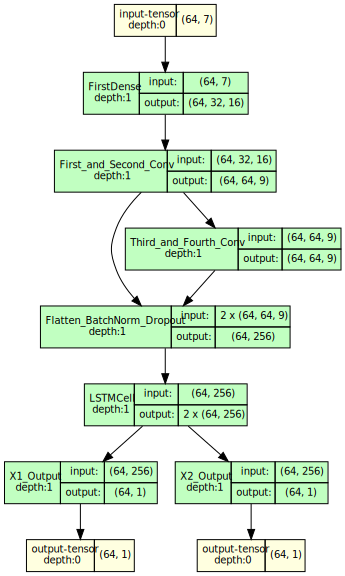

In [115]:
import graphviz
from torchview import draw_graph

model2 = SoftOrdering1DCNN(input_dim=7, output_dim=1, sign_size=16, cha_input=32, cha_hidden=64, K=2,
                         dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2, LSTM_option = True)

for testpred, testtarget in test_loader_nn:
    testpred
    
model_graph = draw_graph(model2, input_size=testpred.shape, show_shapes = True, expand_nested=False, depth = 1)
model_graph.visual_graph #.render('model1', format = 'png')

In [170]:
%%time
from torchmetrics.classification import BinaryPrecision
model = SoftOrdering1DCNN(input_dim=7, output_dim=1, sign_size=16, cha_input=32, cha_hidden=64, K=2,
                         dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
error_multiple = nn.CrossEntropyLoss(); error_binary = nn.BCELoss()

loss_list_train = []; loss_list_test = []; iteration_list = []; accuracy_list_train_freq = []; accuracy_list_train_intensity = []
accuracy_list_test_freq = []; accuracy_list_test_intensity = []; count = 0

for epoch in range(num_epochs):
    for i, (predictors, targets) in enumerate(train_loader_nn):
        optimizer.zero_grad()
        outputs_freq, outputs_intensity = model(predictors)
        frequencies = torch.Tensor([item[0] for item in targets]).unsqueeze(1)
        intensities = torch.Tensor([item[1] for item in targets]).unsqueeze(1)
        
        loss_freq = error_binary(outputs_freq, frequencies); loss_intensity = error_multiple(outputs_intensity, intensities)
        
        total_train = frequencies.size(0)
        loss_hit = 0
        for idx, x in enumerate(frequencies):
            if x == 1:
                loss_hit += x - outputs_freq[idx]
        correct_train_intensity = (torch.round(outputs_intensity) == intensities).sum()
        metric = BinaryPrecision()
        accuracy_train_freq = metric(torch.round(outputs_freq), frequencies)
        accuracy_train_freq = torch.round(100*accuracy_train_freq)
        accuracy_train_intensity = torch.round(100 * correct_train_intensity/total_train)
        loss_total = loss_freq + loss_intensity #+ loss_hit*0.1
        loss_total = torch.round(loss_total)
        loss_total.backward()
        optimizer.step()
        count += 1
        
        for testpred, testtarget in test_loader_nn:
            test_freq_pred, test_intensity_pred = model(testpred)
            test_freq = torch.Tensor([item[0] for item in testtarget]).unsqueeze(1)
            test_intensity = torch.Tensor([item[1] for item in testtarget]).unsqueeze(1)
            loss_freq_test = error_binary(test_freq_pred, test_freq); 
            loss_intensity_test = error_multiple(test_intensity_pred, test_intensity)
            loss_total_test = torch.round(loss_freq_test + loss_intensity_test)
            loss_hit_test = 0
            for idxtest, xtest in enumerate(test_freq):
                if xtest == 1:
                    loss_hit_test += xtest - test_freq_pred[idxtest]
            total_test = test_freq.size(0)
            correct_test_intensity = (torch.round(test_intensity_pred) == test_intensity).sum()
            accuracy_test_freq = metric(torch.round(test_freq_pred), test_freq)
            accuracy_test_freq = torch.round(100*accuracy_test_freq)
            accuracy_test_intensity = torch.round(100 * correct_test_intensity/total_test)
        
        loss_list_train.append(loss_total.data.item())
        iteration_list.append(count)
        accuracy_list_train_freq.append(accuracy_train_freq)
        accuracy_list_train_intensity.append(accuracy_train_intensity)
        accuracy_list_test_freq.append(accuracy_test_freq)
        accuracy_list_test_intensity.append(accuracy_test_intensity)
        print('Iteration: {}. Loss_train_freq: {}. Accuracy_train_freq: {}. Accuracy_train_intensity: {}. Accuracy_test_freq: {}. Accuracy_test_intensity: {}.'\
              .format(count, loss_total.data.item(), accuracy_train_freq, accuracy_train_intensity, accuracy_test_freq, accuracy_test_intensity))

Iteration: 1. Loss_train_freq: 1.0. Accuracy_train_freq: 64.0. Accuracy_train_intensity: 25.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 39.0.
Iteration: 2. Loss_train_freq: 1.0. Accuracy_train_freq: 38.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 36.0.
Iteration: 3. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 31.0. Accuracy_test_freq: 51.0. Accuracy_test_intensity: 34.0.
Iteration: 4. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 31.0.
Iteration: 5. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 36.0.
Iteration: 6. Loss_train_freq: 1.0. Accuracy_train_freq: 39.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 42.0.
Iteration: 7. Loss_train_freq: 1.0. Accuracy_train_freq: 61.0. Accuracy_train_intensity:

Iteration: 55. Loss_train_freq: 1.0. Accuracy_train_freq: 57.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 39.0.
Iteration: 56. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 34.0.
Iteration: 57. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 59.0. Accuracy_test_intensity: 36.0.
Iteration: 58. Loss_train_freq: 1.0. Accuracy_train_freq: 57.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 60.0. Accuracy_test_intensity: 39.0.
Iteration: 59. Loss_train_freq: 1.0. Accuracy_train_freq: 53.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 47.0. Accuracy_test_intensity: 36.0.
Iteration: 60. Loss_train_freq: 1.0. Accuracy_train_freq: 39.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 33.0.
Iteration: 61. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_int

Iteration: 109. Loss_train_freq: 1.0. Accuracy_train_freq: 61.0. Accuracy_train_intensity: 31.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 39.0.
Iteration: 110. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 39.0.
Iteration: 111. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 34.0.
Iteration: 112. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 38.0.
Iteration: 113. Loss_train_freq: 1.0. Accuracy_train_freq: 69.0. Accuracy_train_intensity: 25.0. Accuracy_test_freq: 44.0. Accuracy_test_intensity: 39.0.
Iteration: 114. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 42.0.
Iteration: 115. Loss_train_freq: 1.0. Accuracy_train_freq: 42.0. Accuracy_tr

Iteration: 163. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 41.0. Accuracy_test_intensity: 36.0.
Iteration: 164. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 36.0.
Iteration: 165. Loss_train_freq: 1.0. Accuracy_train_freq: 65.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq: 54.0. Accuracy_test_intensity: 38.0.
Iteration: 166. Loss_train_freq: 1.0. Accuracy_train_freq: 70.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 59.0. Accuracy_test_intensity: 38.0.
Iteration: 167. Loss_train_freq: 1.0. Accuracy_train_freq: 53.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 38.0.
Iteration: 168. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 36.0.
Iteration: 169. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_tr

Iteration: 217. Loss_train_freq: 1.0. Accuracy_train_freq: 32.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 41.0.
Iteration: 218. Loss_train_freq: 1.0. Accuracy_train_freq: 46.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 36.0.
Iteration: 219. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 38.0.
Iteration: 220. Loss_train_freq: 1.0. Accuracy_train_freq: 69.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 60.0. Accuracy_test_intensity: 36.0.
Iteration: 221. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 44.0.
Iteration: 222. Loss_train_freq: 1.0. Accuracy_train_freq: 64.0. Accuracy_train_intensity: 31.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 36.0.
Iteration: 223. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_tr

Iteration: 271. Loss_train_freq: 1.0. Accuracy_train_freq: 46.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 41.0.
Iteration: 272. Loss_train_freq: 1.0. Accuracy_train_freq: 61.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 43.0. Accuracy_test_intensity: 36.0.
Iteration: 273. Loss_train_freq: 1.0. Accuracy_train_freq: 53.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 38.0.
Iteration: 274. Loss_train_freq: 1.0. Accuracy_train_freq: 54.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 42.0.
Iteration: 275. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 31.0.
Iteration: 276. Loss_train_freq: 1.0. Accuracy_train_freq: 34.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 36.0.
Iteration: 277. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_tr

Iteration: 325. Loss_train_freq: 1.0. Accuracy_train_freq: 75.0. Accuracy_train_intensity: 28.0. Accuracy_test_freq: 54.0. Accuracy_test_intensity: 38.0.
Iteration: 326. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_train_intensity: 27.0. Accuracy_test_freq: 43.0. Accuracy_test_intensity: 36.0.
Iteration: 327. Loss_train_freq: 1.0. Accuracy_train_freq: 66.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 36.0.
Iteration: 328. Loss_train_freq: 1.0. Accuracy_train_freq: 51.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 44.0.
Iteration: 329. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 41.0.
Iteration: 330. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 38.0.
Iteration: 331. Loss_train_freq: 1.0. Accuracy_train_freq: 54.0. Accuracy_tr

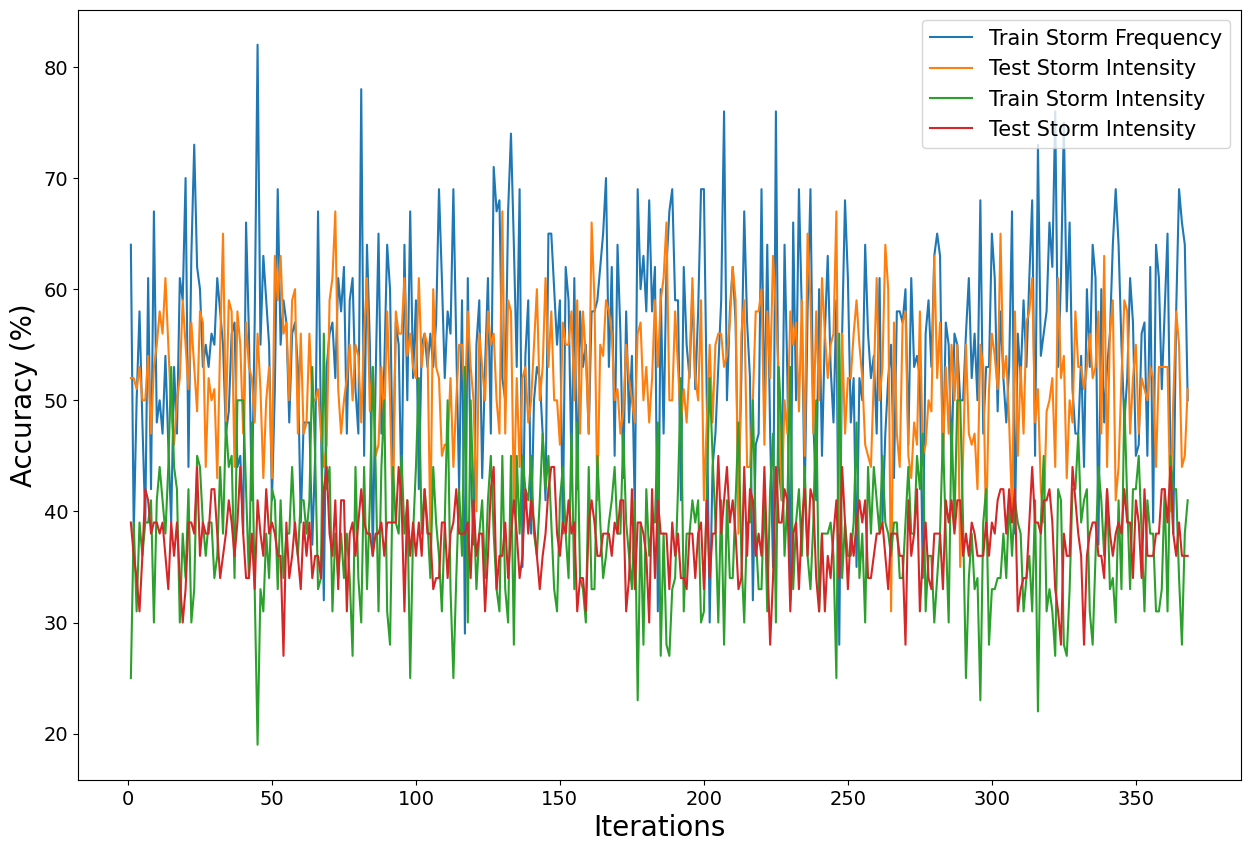

In [171]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, accuracy_list_train_freq, label="Train Storm Frequency")
plt.plot(iteration_list, accuracy_list_test_freq, label="Test Storm Intensity")
plt.plot(iteration_list, accuracy_list_train_intensity, label="Train Storm Intensity")
plt.plot(iteration_list, accuracy_list_test_intensity, label="Test Storm Intensity")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Accuracy (%)', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

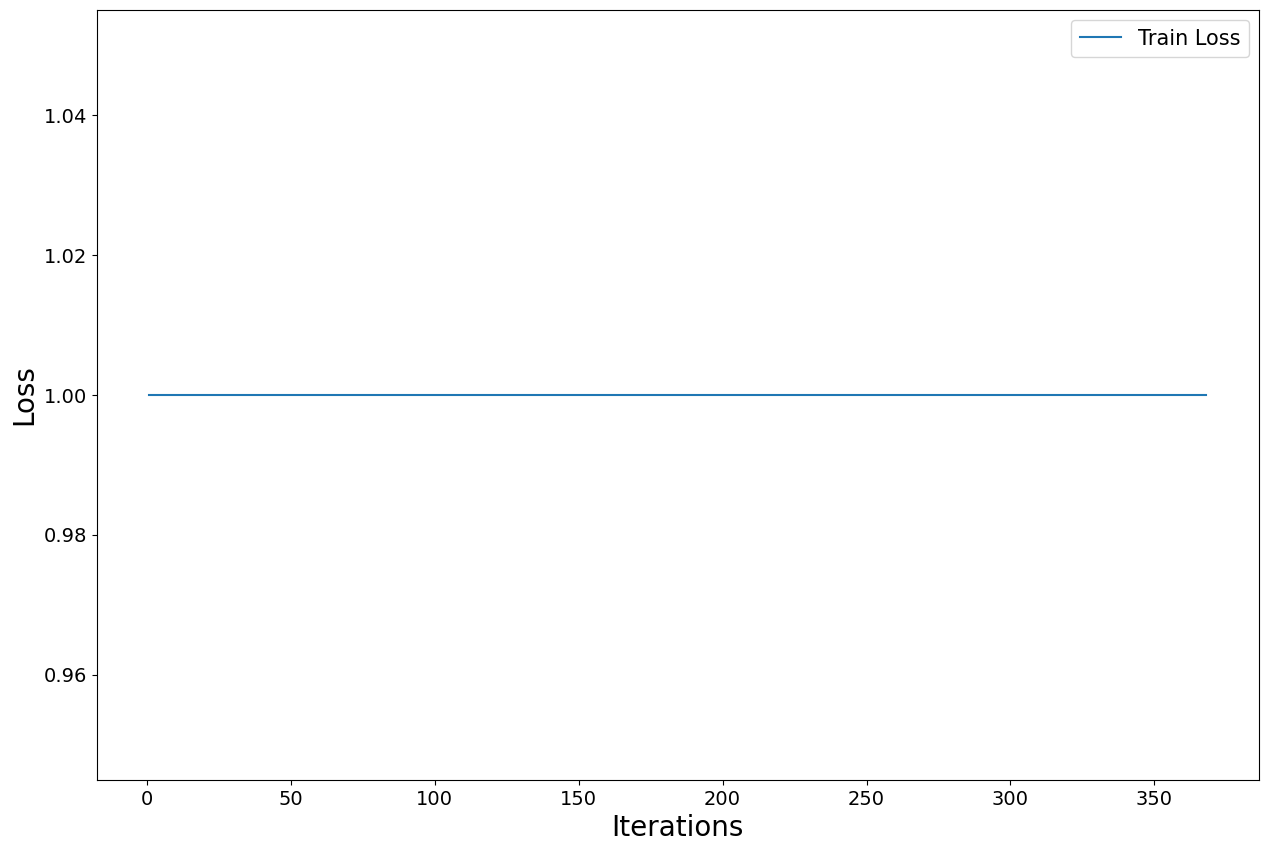

In [172]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, loss_list_train, label="Train Loss")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Loss', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

In [173]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in test_loader_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity test = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq test = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity test =  38.086956
accuracy freq test =  54.97826


In [174]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in unseen_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity unseen = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq unseen = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity unseen =  83.07143
accuracy freq unseen =  0.0


In [124]:
import os
current_dir = os.getcwd()
current_dir

'C:\\Users\\jkuhn\\Documents\\organized\\School\\Northwestern_Masters\\Capstone_Thesis'

In [175]:
# save model 1
torch.save(model.state_dict(), current_dir + r'\Models\Tabular_CNN\tabular_CNN_model5')

# CNN + PINN

In [412]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import imblearn
from imblearn.over_sampling import SMOTE

data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()
data_code

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956

X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_nn = data_nn['tropical_storm_occurence'].values
X_nn, Y_nn = SMOTE().fit_resample(X_nn, Y_nn)
data_nn = pd.DataFrame(np.column_stack([X_nn,Y_nn]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_nn = data_nn[['tropical_storm_occurence','USA_SSHS']].values

X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X_nn, Y_nn, test_size = 0.2, random_state = 42) 

X_train_nn = torch.from_numpy(X_train_nn).float()
X_test_nn = torch.from_numpy(X_test_nn).float()
Y_train_nn = torch.from_numpy(Y_train_nn).type(torch.LongTensor).float()
Y_test_nn = torch.from_numpy(Y_test_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
train_nn = TensorDataset(X_train_nn,Y_train_nn)
test_nn = TensorDataset(X_test_nn,Y_test_nn)

# # batch_size, epoch and iteration
batch_size = 64
n_iters = 700
num_epochs = n_iters / (len(X_train_nn) / batch_size)

num_epochs = int(num_epochs)
print("Epoch Number: ",num_epochs)

# data loader
train_loader_nn = DataLoader(train_nn, batch_size = batch_size, shuffle = False, drop_last=True)
test_loader_nn = DataLoader(test_nn, batch_size = batch_size, shuffle = False, drop_last=True)

Epoch Number:  1


In [413]:
data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']].values

X_unseen_nn = torch.from_numpy(X_unseen_nn).float()
Y_unseen_nn = torch.from_numpy(Y_unseen_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
unseen_nn = TensorDataset(X_unseen_nn,Y_unseen_nn)

# data loader
unseen_nn = DataLoader(unseen_nn, batch_size = batch_size, shuffle = False, drop_last=True)

In [454]:
%%time
from torchmetrics.classification import BinaryPrecision
model = SoftOrdering1DCNN(input_dim=7, output_dim=1, sign_size=16, cha_input=32, cha_hidden=64, K=2,
                         dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
error_multiple = nn.CrossEntropyLoss(); error_binary = nn.BCELoss()

loss_list_train = []; loss_list_test = []; iteration_list = []; accuracy_list_train_freq = []; accuracy_list_train_intensity = []
accuracy_list_test_freq = []; accuracy_list_test_intensity = []; count = 0

for epoch in range(num_epochs):
    for i, (predictors, targets) in enumerate(train_loader_nn):
        optimizer.zero_grad()
        outputs_freq, outputs_intensity = model(predictors)
        frequencies = torch.Tensor([item[0] for item in targets]).unsqueeze(1)
        intensities = torch.Tensor([item[1] for item in targets]).unsqueeze(1)
        
        loss_freq = error_binary(outputs_freq, frequencies); loss_intensity = error_multiple(outputs_intensity, intensities)
        
        total_train = frequencies.size(0)
#         loss_hit = 0
#         for idx, x in enumerate(frequencies):
#             if x == 1:
#                 loss_hit += x - outputs_freq[idx]
        
        loss_pinn = 0
        for idx, l in enumerate(outputs_intensity):
            if torch.round(l) >= 4 and torch.round(outputs_freq[idx]) != 1:
                loss_pinn += 1
                
        correct_train_intensity = (torch.round(outputs_intensity) == intensities).sum()
        metric = BinaryPrecision()
        accuracy_train_freq = metric(torch.round(outputs_freq), frequencies)
        accuracy_train_freq = torch.round(100*accuracy_train_freq)
        accuracy_train_intensity = torch.round(100 * correct_train_intensity/total_train)
        loss_total = loss_freq + loss_intensity + loss_pinn #+ loss_hit*0.1
        loss_total = torch.round(loss_total)
        loss_total.backward()
        optimizer.step()
        count += 1
        
        for testpred, testtarget in test_loader_nn:
            test_freq_pred, test_intensity_pred = model(testpred)
            test_freq = torch.Tensor([item[0] for item in testtarget]).unsqueeze(1)
            test_intensity = torch.Tensor([item[1] for item in testtarget]).unsqueeze(1)
            loss_freq_test = error_binary(test_freq_pred, test_freq); 
            loss_intensity_test = error_multiple(test_intensity_pred, test_intensity)
            loss_total_test = torch.round(loss_freq_test + loss_intensity_test)
            loss_hit_test = 0
            for idxtest, xtest in enumerate(test_freq):
                if xtest == 1:
                    loss_hit_test += xtest - test_freq_pred[idxtest]
            total_test = test_freq.size(0)
            correct_test_intensity = (torch.round(test_intensity_pred) == test_intensity).sum()
            accuracy_test_freq = metric(torch.round(test_freq_pred), test_freq)
            accuracy_test_freq = torch.round(100*accuracy_test_freq)
            accuracy_test_intensity = torch.round(100 * correct_test_intensity/total_test)
        
        loss_list_train.append(loss_total.data.item())
        iteration_list.append(count)
        accuracy_list_train_freq.append(accuracy_train_freq)
        accuracy_list_train_intensity.append(accuracy_train_intensity)
        accuracy_list_test_freq.append(accuracy_test_freq)
        accuracy_list_test_intensity.append(accuracy_test_intensity)
        print('Iteration: {}. Loss_train_freq: {}. Accuracy_train_freq: {}. Accuracy_train_intensity: {}. Accuracy_test_freq: {}. Accuracy_test_intensity: {}.'\
              .format(count, loss_total.data.item(), accuracy_train_freq, accuracy_train_intensity, accuracy_test_freq, accuracy_test_intensity))

Iteration: 1. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 31.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 42.0.
Iteration: 2. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 41.0.
Iteration: 3. Loss_train_freq: 1.0. Accuracy_train_freq: 46.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 67.0. Accuracy_test_intensity: 38.0.
Iteration: 4. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 36.0.
Iteration: 5. Loss_train_freq: 1.0. Accuracy_train_freq: 39.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 36.0.
Iteration: 6. Loss_train_freq: 1.0. Accuracy_train_freq: 41.0. Accuracy_train_intensity: 55.0. Accuracy_test_freq: 59.0. Accuracy_test_intensity: 38.0.
Iteration: 7. Loss_train_freq: 1.0. Accuracy_train_freq: 49.0. Accuracy_train_intensity:

Iteration: 55. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 34.0.
Iteration: 56. Loss_train_freq: 1.0. Accuracy_train_freq: 43.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 41.0.
Iteration: 57. Loss_train_freq: 1.0. Accuracy_train_freq: 49.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 41.0.
Iteration: 58. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 61.0. Accuracy_test_intensity: 39.0.
Iteration: 59. Loss_train_freq: 1.0. Accuracy_train_freq: 42.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 66.0. Accuracy_test_intensity: 42.0.
Iteration: 60. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 41.0.
Iteration: 61. Loss_train_freq: 1.0. Accuracy_train_freq: 60.0. Accuracy_train_int

Iteration: 109. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 39.0.
Iteration: 110. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 38.0.
Iteration: 111. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 34.0.
Iteration: 112. Loss_train_freq: 2.0. Accuracy_train_freq: 67.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 38.0.
Iteration: 113. Loss_train_freq: 1.0. Accuracy_train_freq: 68.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 38.0.
Iteration: 114. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 60.0. Accuracy_test_intensity: 38.0.
Iteration: 115. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_tr

Iteration: 163. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 38.0.
Iteration: 164. Loss_train_freq: 1.0. Accuracy_train_freq: 66.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 44.0.
Iteration: 165. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 42.0.
Iteration: 166. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 36.0.
Iteration: 167. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 62.0. Accuracy_test_intensity: 39.0.
Iteration: 168. Loss_train_freq: 1.0. Accuracy_train_freq: 53.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 38.0.
Iteration: 169. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_tr

Iteration: 217. Loss_train_freq: 1.0. Accuracy_train_freq: 34.0. Accuracy_train_intensity: 55.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 38.0.
Iteration: 218. Loss_train_freq: 1.0. Accuracy_train_freq: 67.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 63.0. Accuracy_test_intensity: 44.0.
Iteration: 219. Loss_train_freq: 1.0. Accuracy_train_freq: 34.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 44.0.
Iteration: 220. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 44.0.
Iteration: 221. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 36.0.
Iteration: 222. Loss_train_freq: 1.0. Accuracy_train_freq: 61.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 39.0.
Iteration: 223. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_tr

Iteration: 271. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 62.0. Accuracy_test_intensity: 36.0.
Iteration: 272. Loss_train_freq: 1.0. Accuracy_train_freq: 39.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 61.0. Accuracy_test_intensity: 42.0.
Iteration: 273. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 41.0.
Iteration: 274. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 64.0. Accuracy_test_intensity: 44.0.
Iteration: 275. Loss_train_freq: 1.0. Accuracy_train_freq: 65.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 39.0.
Iteration: 276. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 38.0.
Iteration: 277. Loss_train_freq: 1.0. Accuracy_train_freq: 66.0. Accuracy_tr

Iteration: 325. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 42.0.
Iteration: 326. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 59.0. Accuracy_test_intensity: 41.0.
Iteration: 327. Loss_train_freq: 1.0. Accuracy_train_freq: 60.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 38.0.
Iteration: 328. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 39.0.
Iteration: 329. Loss_train_freq: 1.0. Accuracy_train_freq: 60.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 65.0. Accuracy_test_intensity: 38.0.
Iteration: 330. Loss_train_freq: 1.0. Accuracy_train_freq: 42.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 42.0. Accuracy_test_intensity: 38.0.
Iteration: 331. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_tr

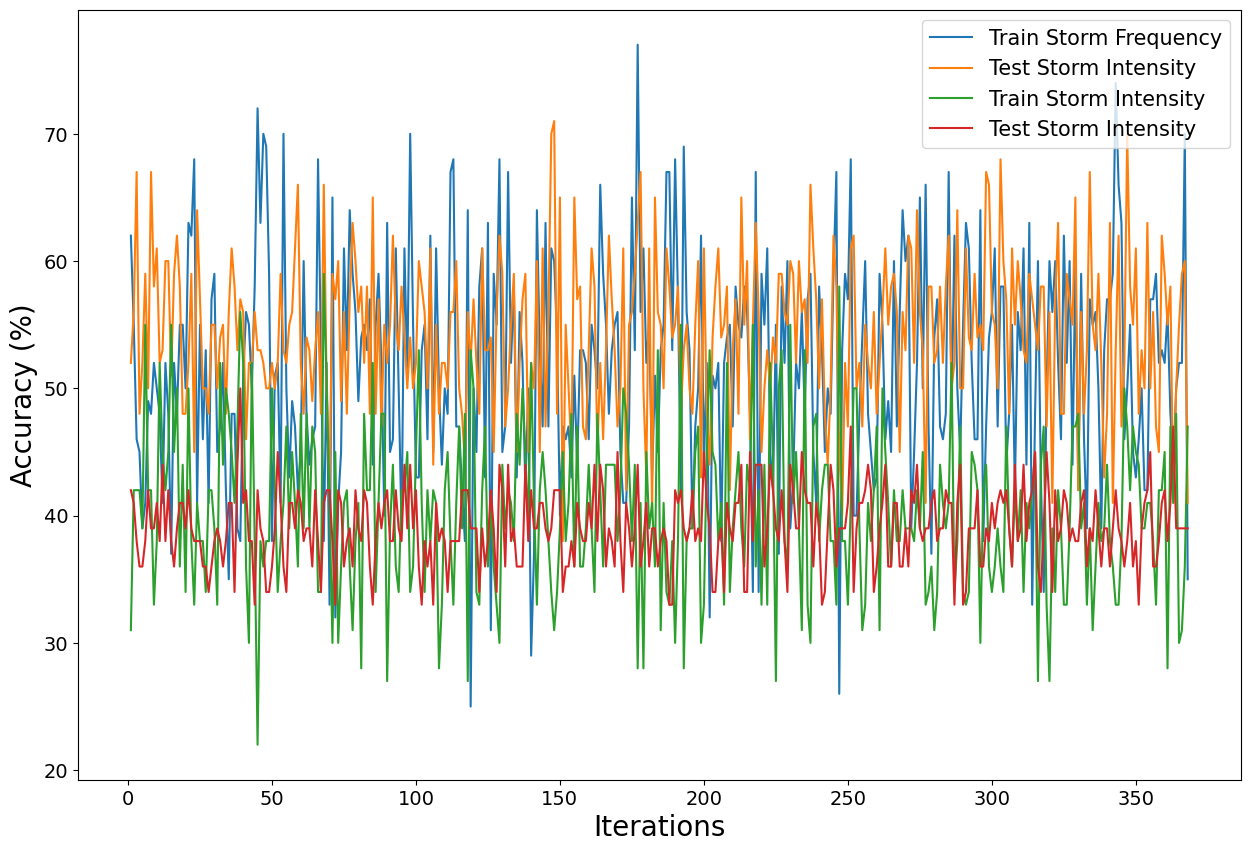

In [455]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, accuracy_list_train_freq, label="Train Storm Frequency")
plt.plot(iteration_list, accuracy_list_test_freq, label="Test Storm Intensity")
plt.plot(iteration_list, accuracy_list_train_intensity, label="Train Storm Intensity")
plt.plot(iteration_list, accuracy_list_test_intensity, label="Test Storm Intensity")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Accuracy (%)', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

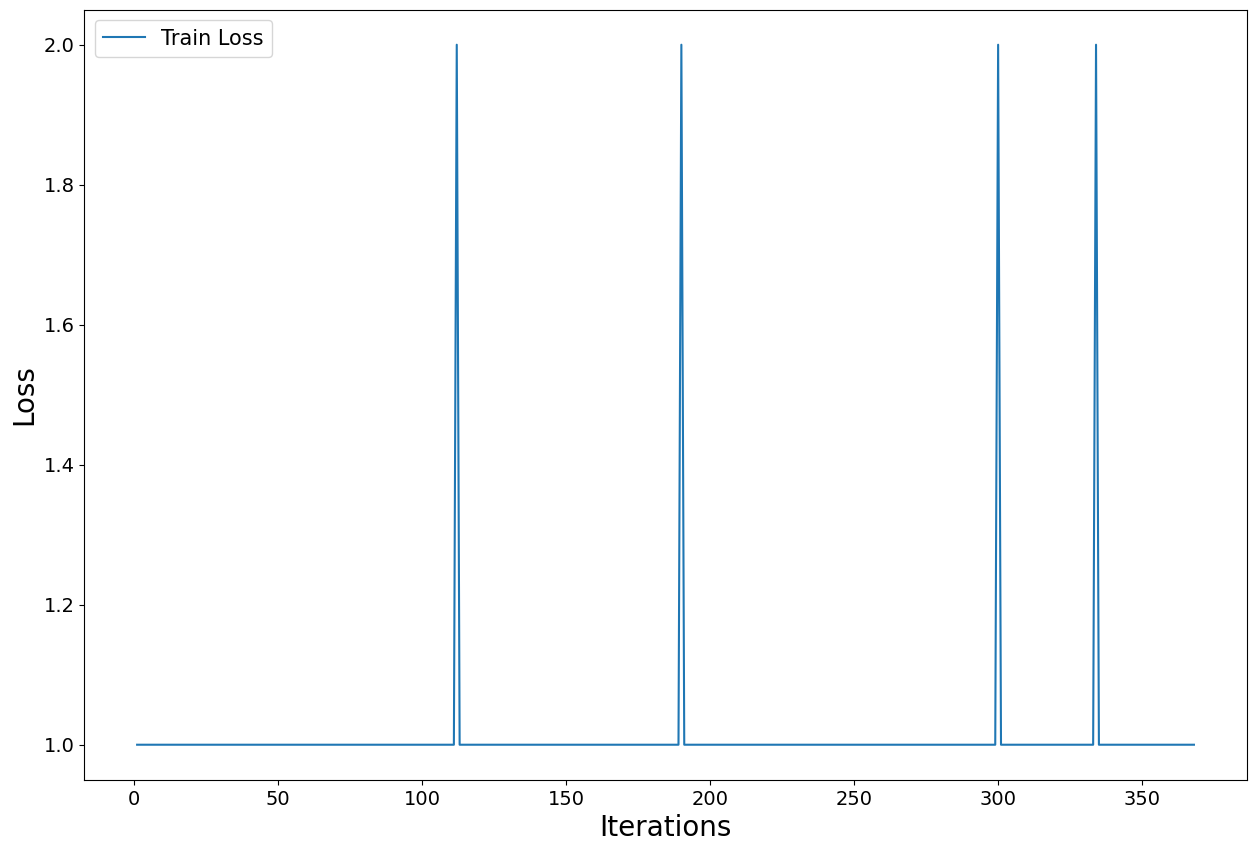

In [456]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, loss_list_train, label="Train Loss")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Loss', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

In [457]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in test_loader_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity test = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq test = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity test =  40.173912
accuracy freq test =  52.391304


In [458]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in unseen_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity unseen = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq unseen = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity unseen =  84.14286
accuracy freq unseen =  0.21428572


In [422]:
import os
current_dir = os.getcwd()
current_dir

'C:\\Users\\jkuhn\\Documents\\organized\\School\\Northwestern_Masters\\Capstone_Thesis'

In [459]:
# save model 1
torch.save(model.state_dict(), current_dir + r'\Models\CNN_PINN\CNN_PINN_model5')

# Neural Network with picture

# UNet

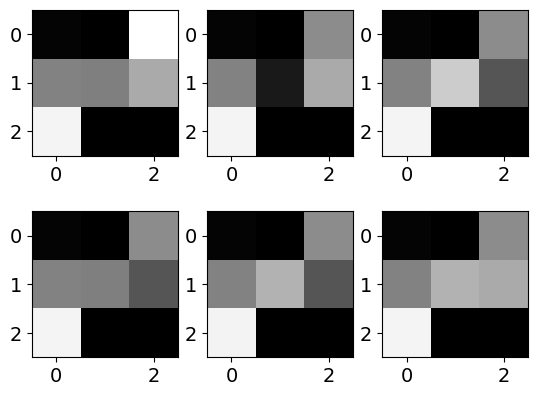

In [176]:
#### testing code ###########
from sklearn.datasets import fetch_covtype
from tab2img.converter import Tab2Img
from sklearn import preprocessing
from PIL import Image

train = (X_nn)
target = np.array([item[1] for item in Y_nn]).reshape(-1, 1)
scaler = preprocessing.MinMaxScaler().fit(train)
X_scaled_train = scaler.transform(train)

model = Tab2Img()
images = model.fit_transform(X_scaled_train, target)
train_images = model.transform(X_scaled_train)
image = Image.fromarray((train_images*255).astype(np.uint8))

fig,ax = plt.subplots(2,3)
for i in range(6):
    nparray = train_images[i].reshape(3,3)
    image = Image.fromarray(nparray * 255)
    ax[i%2][i//2].imshow(image)
fig.show()

In [178]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import imblearn
from imblearn.over_sampling import SMOTE

data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956

# X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','average_Methane_ppb', 'USA_SSHS']].values
X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_nn = data_nn['tropical_storm_occurence'].values
X_nn, Y_nn = SMOTE().fit_resample(X_nn, Y_nn)
data_nn = pd.DataFrame(np.column_stack([X_nn,Y_nn]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_nn = data_nn[['tropical_storm_occurence','USA_SSHS']].values

# convert train x labels to images #
target = np.array([item[1] for item in Y_nn]).reshape(-1, 1)
scaler = preprocessing.MinMaxScaler().fit(X_nn)
X_scaled = scaler.transform(X_nn)
model = Tab2Img()
images = model.fit_transform(X_scaled, target)
X_image = model.transform(X_scaled)

X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X_image, Y_nn, test_size = 0.2, random_state = 42) 

X_train_nn = torch.from_numpy(X_train_nn).float()
X_test_nn = torch.from_numpy(X_test_nn).float()
Y_train_nn = torch.from_numpy(Y_train_nn).type(torch.LongTensor).float()
Y_test_nn = torch.from_numpy(Y_test_nn).type(torch.LongTensor).float()

print(X_train_nn.shape)

# # Pytorch train and test sets
train_nn = TensorDataset(X_train_nn,Y_train_nn)
test_nn = TensorDataset(X_test_nn,Y_test_nn)

# # batch_size, epoch and iteration
batch_size = 64
n_iters = 700
num_epochs = n_iters / (len(X_train_nn) / batch_size)

num_epochs = int(num_epochs)
print("Epoch Number: ",num_epochs)

# data loader
train_loader_nn = DataLoader(train_nn, batch_size = batch_size, shuffle = False, drop_last=True)
test_loader_nn = DataLoader(test_nn, batch_size = batch_size, shuffle = False, drop_last=True)

torch.Size([23604, 3, 3])
Epoch Number:  1


In [181]:
X_unseen_nn.shape

torch.Size([29506, 3, 3])

In [184]:
data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()

X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_nn = data_nn['tropical_storm_occurence'].values
X_nn, Y_nn = SMOTE().fit_resample(X_nn, Y_nn)
data_nn = pd.DataFrame(np.column_stack([X_nn,Y_nn]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_nn = data_nn[['tropical_storm_occurence','USA_SSHS']].values

# convert train x labels to images #
target = np.array([item[1] for item in Y_nn]).reshape(-1, 1)
scaler = preprocessing.MinMaxScaler().fit(X_nn)
X_scaled = scaler.transform(X_nn)
model = Tab2Img()
images = model.fit_transform(X_scaled, target)
X_image = model.transform(X_scaled)

X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X_image, Y_nn, test_size = 0.2, random_state = 42) 

X_train_nn = torch.from_numpy(X_train_nn).float()
X_test_nn = torch.from_numpy(X_test_nn).float()
Y_train_nn = torch.from_numpy(Y_train_nn).type(torch.LongTensor).float()
Y_test_nn = torch.from_numpy(Y_test_nn).type(torch.LongTensor).float()

print(X_train_nn.shape)
print(Y_train_nn.shape)

# # Pytorch train and test sets
train_nn = TensorDataset(X_train_nn,Y_train_nn)
test_nn = TensorDataset(X_test_nn,Y_test_nn)

# data loader
train_loader_nn = DataLoader(train_nn, batch_size = batch_size, shuffle = False, drop_last=True)
test_loader_nn = DataLoader(test_nn, batch_size = batch_size, shuffle = False, drop_last=True)

torch.Size([23604, 3, 3])
torch.Size([23604, 2])


In [188]:
data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']].values

# convert train x labels to images #
target_unseen = np.array([item[1] for item in Y_unseen_nn]).reshape(-1, 1)
scaler_unseen = preprocessing.MinMaxScaler().fit(X_unseen_nn)
X_scaled_unseen = scaler.transform(X_unseen_nn)
model_unseen = Tab2Img()
images_unseen = model_unseen.fit_transform(X_scaled_unseen, target_unseen)
X_unseen_nn = model_unseen.transform(X_scaled_unseen)

X_unseen_nn = torch.from_numpy(X_unseen_nn).float()
Y_unseen_nn = torch.from_numpy(Y_unseen_nn).type(torch.LongTensor).float()

print(X_unseen_nn.shape)
print(Y_unseen_nn.shape)

# # Pytorch train and test sets
unseen_nn = TensorDataset(X_unseen_nn,Y_unseen_nn)

# data loader
unseen_nn = DataLoader(unseen_nn, batch_size = batch_size, shuffle = False, drop_last=True)

torch.Size([903, 3, 3])
torch.Size([903, 2])


In [189]:
import torch
from torch import nn
import pytorch_lightning as pl

class SoftOrdering1DCNN_image(pl.LightningModule):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2, LSTM_option = False):
        super().__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        self.loss = nn.BCEWithLogitsLoss()

#         self.first_dense = FirstDense(input_dim, dropout_input, sign_size, cha_input)
        self.first_and_second_conv = First_and_Second_Conv(cha_input, K, sign_size, dropout_hidden, cha_hidden)
        self.third_and_fourth_conv = Third_and_Fourth_Conv(cha_hidden, dropout_hidden)
        self.flatten_batchNorm_dropout = Flatten_BatchNorm_Dropout(sign_size, cha_hidden, dropout_output)
        self.x1_output = X1_Output(sign_size, cha_hidden, output_dim)
        self.x2_output = X2_Output(sign_size, cha_hidden, output_dim)
        
        self.LSTM_option = LSTM_option
        self.lstm1 = nn.LSTMCell(256, 256)
        self.lstm2 = nn.LSTMCell(256, 256)
        
    def forward(self, x):
#         x = self.first_dense(x)
        x = self.first_and_second_conv(x)
        x_s = x
        x = self.third_and_fourth_conv(x)

        x = self.flatten_batchNorm_dropout(x, x_s)
        
        if self.LSTM_option:
            x, _ = self.lstm1(x)

        x1 = self.x1_output(x)
        x2 = self.x2_output(x)
        
        return x1, x2

In [215]:
%%time
from torchmetrics.classification import BinaryPrecision
# model = UNet()
model = SoftOrdering1DCNN_image(input_dim=3, output_dim=1, sign_size=16, cha_input=3, cha_hidden=64, K=2,
                         dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
error_multiple = nn.CrossEntropyLoss(); error_binary = nn.BCELoss()

loss_list_train = []; loss_list_test = []; iteration_list = []; accuracy_list_train_freq = []; accuracy_list_train_intensity = []
accuracy_list_test_freq = []; accuracy_list_test_intensity = []; count = 0

for epoch in range(num_epochs):
    for i, (predictors, targets) in enumerate(train_loader_nn):
        optimizer.zero_grad()
        print(predictors.shape)
        outputs_freq, outputs_intensity = model(predictors)
        frequencies = torch.Tensor([item[0] for item in targets]).unsqueeze(1)
        intensities = torch.Tensor([item[1] for item in targets]).unsqueeze(1)
        
        loss_freq = error_binary(outputs_freq, frequencies); loss_intensity = error_multiple(outputs_intensity, intensities)
        
        total_train = frequencies.size(0)
        loss_hit = 0
        for idx, x in enumerate(frequencies):
            if x == 1:
                loss_hit += x - outputs_freq[idx]
        correct_train_intensity = (torch.round(outputs_intensity) == intensities).sum()
        metric = BinaryPrecision()
        accuracy_train_freq = metric(torch.round(outputs_freq), frequencies)
        accuracy_train_freq = torch.round(100*accuracy_train_freq)
        accuracy_train_intensity = torch.round(100 * correct_train_intensity/total_train)
        loss_total = loss_freq + loss_intensity #+ loss_hit*0.1
        loss_total = torch.round(loss_total)
        loss_total.backward()
        optimizer.step()
        count += 1
        
        for testpred, testtarget in test_loader_nn:
            test_freq_pred, test_intensity_pred = model(testpred)
            test_freq = torch.Tensor([item[0] for item in testtarget]).unsqueeze(1)
            test_intensity = torch.Tensor([item[1] for item in testtarget]).unsqueeze(1)
            loss_freq_test = error_binary(test_freq_pred, test_freq); 
            loss_intensity_test = error_multiple(test_intensity_pred, test_intensity)
            loss_total_test = torch.round(loss_freq_test + loss_intensity_test)
            loss_hit_test = 0
            for idxtest, xtest in enumerate(test_freq):
                if xtest == 1:
                    loss_hit_test += xtest - test_freq_pred[idxtest]
            total_test = test_freq.size(0)
            correct_test_intensity = (torch.round(test_intensity_pred) == test_intensity).sum()
            accuracy_test_freq = metric(torch.round(test_freq_pred), test_freq)
            accuracy_test_freq = torch.round(100*accuracy_test_freq)
            accuracy_test_intensity = torch.round(100 * correct_test_intensity/total_test)
        
        loss_list_train.append(loss_total.data.item())
        iteration_list.append(count)
        accuracy_list_train_freq.append(accuracy_train_freq)
        accuracy_list_train_intensity.append(accuracy_train_intensity)
        accuracy_list_test_freq.append(accuracy_test_freq)
        accuracy_list_test_intensity.append(accuracy_test_intensity)
        print('Iteration: {}. Loss_train_freq: {}. Accuracy_train_freq: {}. Accuracy_train_intensity: {}. Accuracy_test_freq: {}. Accuracy_test_intensity: {}.'\
              .format(count, loss_total.data.item(), accuracy_train_freq, accuracy_train_intensity, accuracy_test_freq, accuracy_test_intensity))

torch.Size([64, 3, 3])
Iteration: 1. Loss_train_freq: 1.0. Accuracy_train_freq: 67.0. Accuracy_train_intensity: 31.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 44.0.
torch.Size([64, 3, 3])
Iteration: 2. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 41.0.
torch.Size([64, 3, 3])
Iteration: 3. Loss_train_freq: 1.0. Accuracy_train_freq: 53.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 44.0. Accuracy_test_intensity: 39.0.
torch.Size([64, 3, 3])
Iteration: 4. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 5. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 34.0.
torch.Size([64, 3, 3])
Iteration: 6. Loss_train_freq: 1.0. Accuracy_train_freq: 41.0. Accuracy_train_intensity: 47.0. Accurac

Iteration: 48. Loss_train_freq: 1.0. Accuracy_train_freq: 64.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 49. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 61.0. Accuracy_test_intensity: 45.0.
torch.Size([64, 3, 3])
Iteration: 50. Loss_train_freq: 1.0. Accuracy_train_freq: 37.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 51. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 52. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 41.0.
torch.Size([64, 3, 3])
Iteration: 53. Loss_train_freq: 1.0. Accuracy_train_freq: 46.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 58.0

Iteration: 95. Loss_train_freq: 1.0. Accuracy_train_freq: 42.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 34.0.
torch.Size([64, 3, 3])
Iteration: 96. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 97. Loss_train_freq: 1.0. Accuracy_train_freq: 42.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 98. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 99. Loss_train_freq: 1.0. Accuracy_train_freq: 64.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 49.0. Accuracy_test_intensity: 36.0.
torch.Size([64, 3, 3])
Iteration: 100. Loss_train_freq: 1.0. Accuracy_train_freq: 65.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 52.

Iteration: 142. Loss_train_freq: 1.0. Accuracy_train_freq: 57.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 33.0.
torch.Size([64, 3, 3])
Iteration: 143. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 144. Loss_train_freq: 1.0. Accuracy_train_freq: 49.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 41.0.
torch.Size([64, 3, 3])
Iteration: 145. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 39.0.
torch.Size([64, 3, 3])
Iteration: 146. Loss_train_freq: 1.0. Accuracy_train_freq: 46.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 147. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq

Iteration: 189. Loss_train_freq: 1.0. Accuracy_train_freq: 60.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 59.0. Accuracy_test_intensity: 45.0.
torch.Size([64, 3, 3])
Iteration: 190. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_train_intensity: 30.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 31.0.
torch.Size([64, 3, 3])
Iteration: 191. Loss_train_freq: 1.0. Accuracy_train_freq: 46.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 54.0. Accuracy_test_intensity: 34.0.
torch.Size([64, 3, 3])
Iteration: 192. Loss_train_freq: 1.0. Accuracy_train_freq: 41.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 61.0. Accuracy_test_intensity: 36.0.
torch.Size([64, 3, 3])
Iteration: 193. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 30.0. Accuracy_test_freq: 54.0. Accuracy_test_intensity: 39.0.
torch.Size([64, 3, 3])
Iteration: 194. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq

Iteration: 236. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 59.0. Accuracy_test_intensity: 36.0.
torch.Size([64, 3, 3])
Iteration: 237. Loss_train_freq: 1.0. Accuracy_train_freq: 61.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 39.0.
torch.Size([64, 3, 3])
Iteration: 238. Loss_train_freq: 1.0. Accuracy_train_freq: 38.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 239. Loss_train_freq: 1.0. Accuracy_train_freq: 41.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 60.0. Accuracy_test_intensity: 44.0.
torch.Size([64, 3, 3])
Iteration: 240. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 31.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 47.0.
torch.Size([64, 3, 3])
Iteration: 241. Loss_train_freq: 1.0. Accuracy_train_freq: 41.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq

Iteration: 283. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 41.0.
torch.Size([64, 3, 3])
Iteration: 284. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 36.0.
torch.Size([64, 3, 3])
Iteration: 285. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 44.0.
torch.Size([64, 3, 3])
Iteration: 286. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 287. Loss_train_freq: 1.0. Accuracy_train_freq: 53.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 36.0.
torch.Size([64, 3, 3])
Iteration: 288. Loss_train_freq: 1.0. Accuracy_train_freq: 33.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq

Iteration: 330. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 36.0.
torch.Size([64, 3, 3])
Iteration: 331. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 33.0.
torch.Size([64, 3, 3])
Iteration: 332. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 38.0.
torch.Size([64, 3, 3])
Iteration: 333. Loss_train_freq: 1.0. Accuracy_train_freq: 51.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 44.0. Accuracy_test_intensity: 36.0.
torch.Size([64, 3, 3])
Iteration: 334. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 41.0.
torch.Size([64, 3, 3])
Iteration: 335. Loss_train_freq: 1.0. Accuracy_train_freq: 65.0. Accuracy_train_intensity: 28.0. Accuracy_test_freq

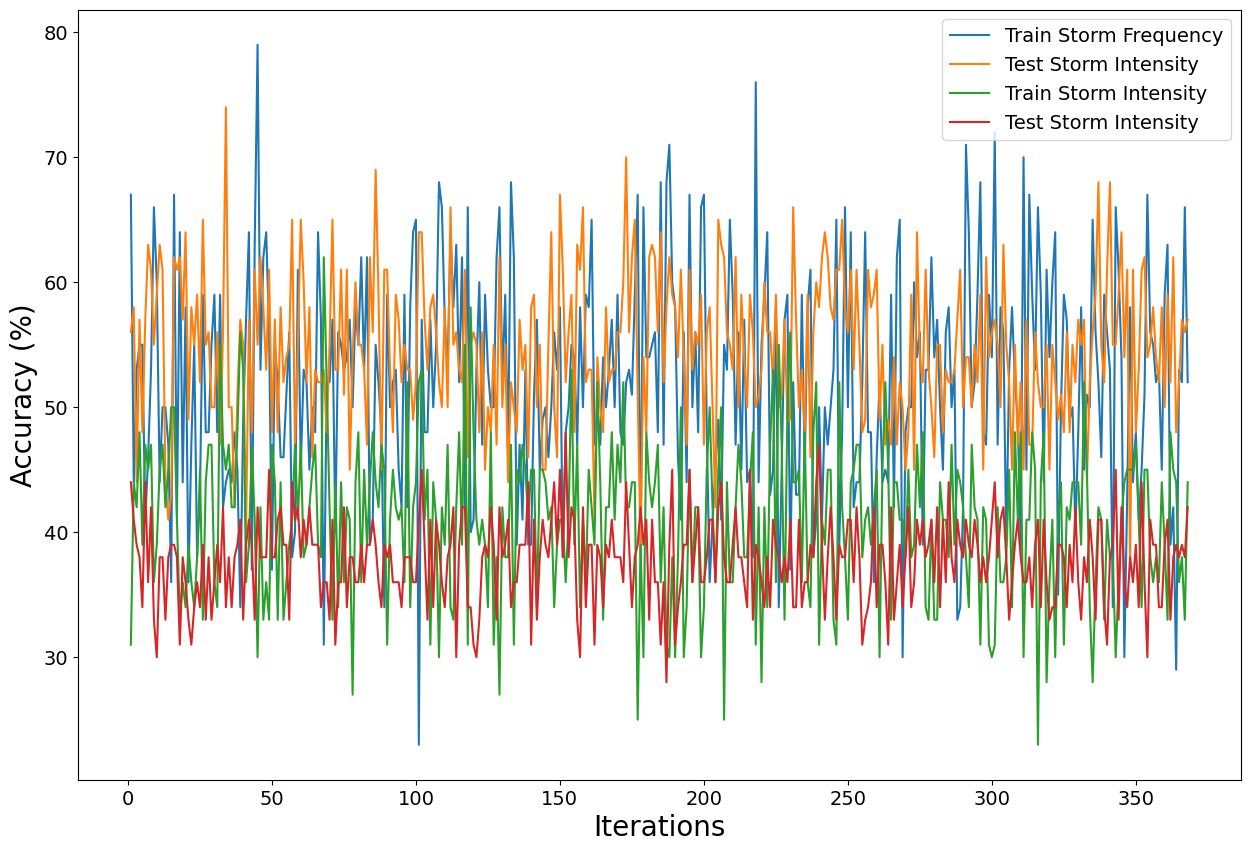

In [216]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, accuracy_list_train_freq, label="Train Storm Frequency")
plt.plot(iteration_list, accuracy_list_test_freq, label="Test Storm Intensity")
plt.plot(iteration_list, accuracy_list_train_intensity, label="Train Storm Intensity")
plt.plot(iteration_list, accuracy_list_test_intensity, label="Test Storm Intensity")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Accuracy (%)', fontsize = 20);
plt.legend(loc = 'best')

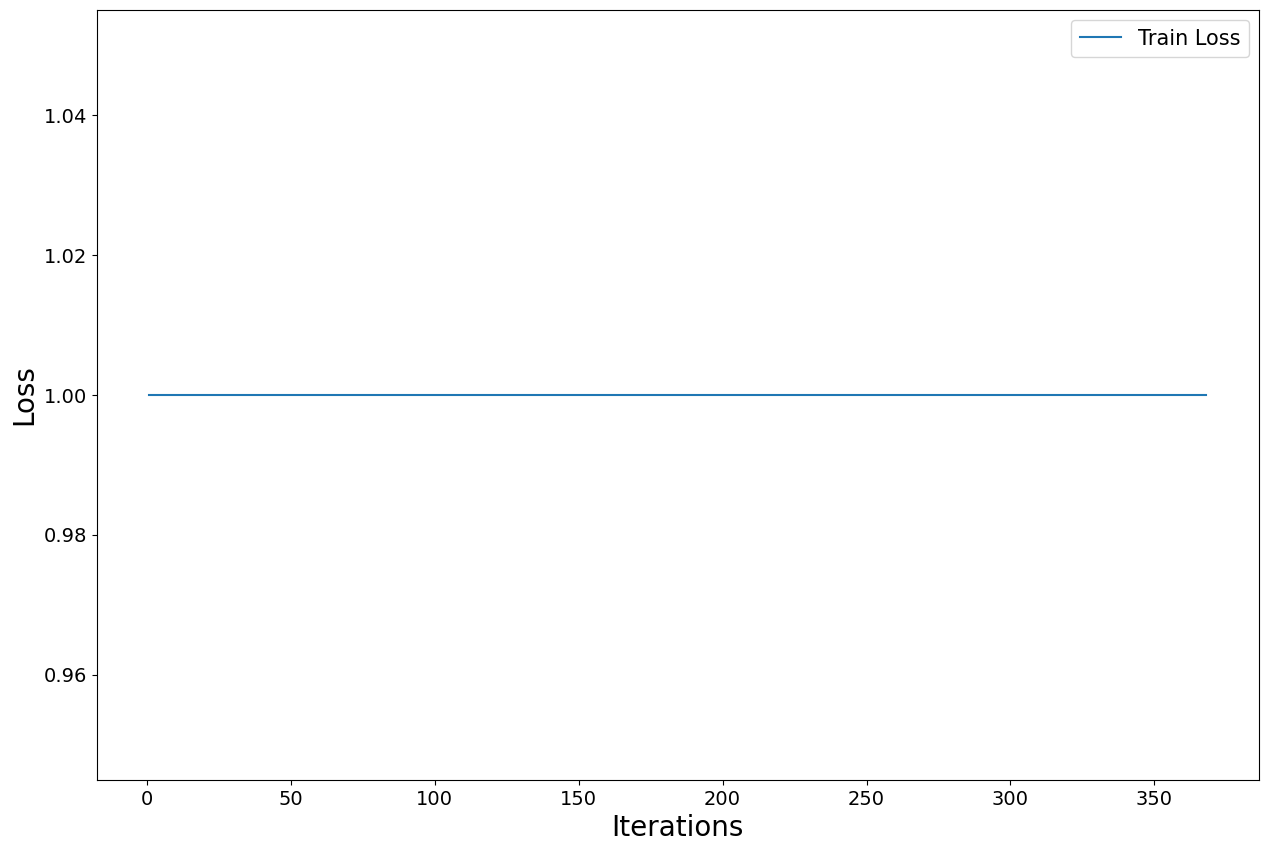

In [217]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, loss_list_train, label="Train Loss")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Loss', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

In [218]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in test_loader_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity test = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq test = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity test =  40.891304
accuracy freq test =  52.673912


In [219]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in unseen_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity unseen = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq unseen = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity unseen =  78.0
accuracy freq unseen =  0.0


In [220]:
# save model 1
torch.save(model.state_dict(), current_dir + r'\Models\Image_CNN\tabular_CNN_model5')

# CNN + LSTM decoder

In [378]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import imblearn
from imblearn.over_sampling import SMOTE

data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956

X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_nn = data_nn['tropical_storm_occurence'].values
X_nn, Y_nn = SMOTE().fit_resample(X_nn, Y_nn)
data_nn = pd.DataFrame(np.column_stack([X_nn,Y_nn]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_nn = data_nn[['tropical_storm_occurence','USA_SSHS']].values

X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X_nn, Y_nn, test_size = 0.2, random_state = 42) 

X_train_nn = torch.from_numpy(X_train_nn).float()
X_test_nn = torch.from_numpy(X_test_nn).float()
Y_train_nn = torch.from_numpy(Y_train_nn).type(torch.LongTensor).float()
Y_test_nn = torch.from_numpy(Y_test_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
train_nn = TensorDataset(X_train_nn,Y_train_nn)
test_nn = TensorDataset(X_test_nn,Y_test_nn)

# # batch_size, epoch and iteration
batch_size = 64
n_iters = 700
num_epochs = n_iters / (len(X_train_nn) / batch_size)

num_epochs = int(num_epochs)
print("Epoch Number: ",num_epochs)

# data loader
train_loader_nn = DataLoader(train_nn, batch_size = batch_size, shuffle = False, drop_last=True)
test_loader_nn = DataLoader(test_nn, batch_size = batch_size, shuffle = False, drop_last=True)

Epoch Number:  1


In [406]:
%%time
from torchmetrics.classification import BinaryPrecision
model = SoftOrdering1DCNN(input_dim=7, output_dim=1, sign_size=16, cha_input=32, cha_hidden=64, K=2,
                         dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2, LSTM_option = True)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
error_multiple = nn.CrossEntropyLoss(); error_binary = nn.BCELoss()

loss_list_train = []; loss_list_test = []; iteration_list = []; accuracy_list_train_freq = []; accuracy_list_train_intensity = []
accuracy_list_test_freq = []; accuracy_list_test_intensity = []; count = 0

for epoch in range(num_epochs):
    for i, (predictors, targets) in enumerate(train_loader_nn):
        optimizer.zero_grad()
        outputs_freq, outputs_intensity = model(predictors)
        frequencies = torch.Tensor([item[0] for item in targets]).unsqueeze(1)
        intensities = torch.Tensor([item[1] for item in targets]).unsqueeze(1)
        
        loss_freq = error_binary(outputs_freq, frequencies); loss_intensity = error_multiple(outputs_intensity, intensities)
        
        total_train = frequencies.size(0)
        loss_hit = 0
        for idx, x in enumerate(frequencies):
            if x == 1:
                loss_hit += x - outputs_freq[idx]
        correct_train_intensity = (torch.round(outputs_intensity) == intensities).sum()
        metric = BinaryPrecision()
        accuracy_train_freq = metric(torch.round(outputs_freq), frequencies)
        accuracy_train_freq = torch.round(100*accuracy_train_freq)
        accuracy_train_intensity = torch.round(100 * correct_train_intensity/total_train)
        loss_total = loss_freq + loss_intensity #+ loss_hit*0.1
        loss_total = torch.round(loss_total)
        loss_total.backward()
        optimizer.step()
        count += 1
        
        for testpred, testtarget in test_loader_nn:
            test_freq_pred, test_intensity_pred = model(testpred)
            test_freq = torch.Tensor([item[0] for item in testtarget]).unsqueeze(1)
            test_intensity = torch.Tensor([item[1] for item in testtarget]).unsqueeze(1)
            loss_freq_test = error_binary(test_freq_pred, test_freq); 
            loss_intensity_test = error_multiple(test_intensity_pred, test_intensity)
            loss_total_test = torch.round(loss_freq_test + loss_intensity_test)
            loss_hit_test = 0
            for idxtest, xtest in enumerate(test_freq):
                if xtest == 1:
                    loss_hit_test += xtest - test_freq_pred[idxtest]
            total_test = test_freq.size(0)
            correct_test_intensity = (torch.round(test_intensity_pred) == test_intensity).sum()
            accuracy_test_freq = metric(torch.round(test_freq_pred), test_freq)
            accuracy_test_freq = torch.round(100*accuracy_test_freq)
            accuracy_test_intensity = torch.round(100 * correct_test_intensity/total_test)
        
        loss_list_train.append(loss_total.data.item())
        iteration_list.append(count)
        accuracy_list_train_freq.append(accuracy_train_freq)
        accuracy_list_train_intensity.append(accuracy_train_intensity)
        accuracy_list_test_freq.append(accuracy_test_freq)
        accuracy_list_test_intensity.append(accuracy_test_intensity)
        print('Iteration: {}. Loss_train_freq: {}. Accuracy_train_freq: {}. Accuracy_train_intensity: {}. Accuracy_test_freq: {}. Accuracy_test_intensity: {}.'\
              .format(count, loss_total.data.item(), accuracy_train_freq, accuracy_train_intensity, accuracy_test_freq, accuracy_test_intensity))

Iteration: 1. Loss_train_freq: 1.0. Accuracy_train_freq: 63.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 61.0. Accuracy_test_intensity: 48.0.
Iteration: 2. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_train_intensity: 53.0. Accuracy_test_freq: 51.0. Accuracy_test_intensity: 48.0.
Iteration: 3. Loss_train_freq: 1.0. Accuracy_train_freq: 39.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 48.0.
Iteration: 4. Loss_train_freq: 1.0. Accuracy_train_freq: 46.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 48.0.
Iteration: 5. Loss_train_freq: 1.0. Accuracy_train_freq: 36.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 59.0. Accuracy_test_intensity: 48.0.
Iteration: 6. Loss_train_freq: 1.0. Accuracy_train_freq: 41.0. Accuracy_train_intensity: 59.0. Accuracy_test_freq: 49.0. Accuracy_test_intensity: 48.0.
Iteration: 7. Loss_train_freq: 1.0. Accuracy_train_freq: 38.0. Accuracy_train_intensity:

Iteration: 55. Loss_train_freq: 1.0. Accuracy_train_freq: 49.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 47.0. Accuracy_test_intensity: 48.0.
Iteration: 56. Loss_train_freq: 1.0. Accuracy_train_freq: 53.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 68.0. Accuracy_test_intensity: 48.0.
Iteration: 57. Loss_train_freq: 1.0. Accuracy_train_freq: 51.0. Accuracy_train_intensity: 55.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 48.0.
Iteration: 58. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 44.0. Accuracy_test_intensity: 48.0.
Iteration: 59. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 48.0.
Iteration: 60. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 53.0. Accuracy_test_freq: 51.0. Accuracy_test_intensity: 48.0.
Iteration: 61. Loss_train_freq: 1.0. Accuracy_train_freq: 54.0. Accuracy_train_int

Iteration: 109. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 48.0.
Iteration: 110. Loss_train_freq: 1.0. Accuracy_train_freq: 43.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 44.0. Accuracy_test_intensity: 48.0.
Iteration: 111. Loss_train_freq: 1.0. Accuracy_train_freq: 41.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 48.0.
Iteration: 112. Loss_train_freq: 1.0. Accuracy_train_freq: 54.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 48.0.
Iteration: 113. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 48.0.
Iteration: 114. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 48.0.
Iteration: 115. Loss_train_freq: 1.0. Accuracy_train_freq: 37.0. Accuracy_tr

Iteration: 163. Loss_train_freq: 1.0. Accuracy_train_freq: 38.0. Accuracy_train_intensity: 58.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 48.0.
Iteration: 164. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 44.0. Accuracy_test_intensity: 48.0.
Iteration: 165. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 49.0. Accuracy_test_intensity: 48.0.
Iteration: 166. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 51.0. Accuracy_test_intensity: 48.0.
Iteration: 167. Loss_train_freq: 1.0. Accuracy_train_freq: 42.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 48.0.
Iteration: 168. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 53.0. Accuracy_test_intensity: 48.0.
Iteration: 169. Loss_train_freq: 1.0. Accuracy_train_freq: 36.0. Accuracy_tr

Iteration: 217. Loss_train_freq: 1.0. Accuracy_train_freq: 27.0. Accuracy_train_intensity: 62.0. Accuracy_test_freq: 40.0. Accuracy_test_intensity: 48.0.
Iteration: 218. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 48.0.
Iteration: 219. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 40.0. Accuracy_test_intensity: 48.0.
Iteration: 220. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 43.0. Accuracy_test_intensity: 48.0.
Iteration: 221. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 47.0. Accuracy_test_intensity: 48.0.
Iteration: 222. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 48.0.
Iteration: 223. Loss_train_freq: 1.0. Accuracy_train_freq: 39.0. Accuracy_tr

Iteration: 271. Loss_train_freq: 1.0. Accuracy_train_freq: 42.0. Accuracy_train_intensity: 53.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 48.0.
Iteration: 272. Loss_train_freq: 1.0. Accuracy_train_freq: 40.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 51.0. Accuracy_test_intensity: 48.0.
Iteration: 273. Loss_train_freq: 1.0. Accuracy_train_freq: 57.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 48.0.
Iteration: 274. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 55.0. Accuracy_test_freq: 49.0. Accuracy_test_intensity: 48.0.
Iteration: 275. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 42.0. Accuracy_test_intensity: 48.0.
Iteration: 276. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 58.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 48.0.
Iteration: 277. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_tr

Iteration: 325. Loss_train_freq: 1.0. Accuracy_train_freq: 67.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 54.0. Accuracy_test_intensity: 48.0.
Iteration: 326. Loss_train_freq: 1.0. Accuracy_train_freq: 43.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 48.0.
Iteration: 327. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 48.0.
Iteration: 328. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 43.0. Accuracy_test_intensity: 48.0.
Iteration: 329. Loss_train_freq: 1.0. Accuracy_train_freq: 42.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 48.0.
Iteration: 330. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 44.0. Accuracy_test_intensity: 48.0.
Iteration: 331. Loss_train_freq: 1.0. Accuracy_train_freq: 58.0. Accuracy_tr

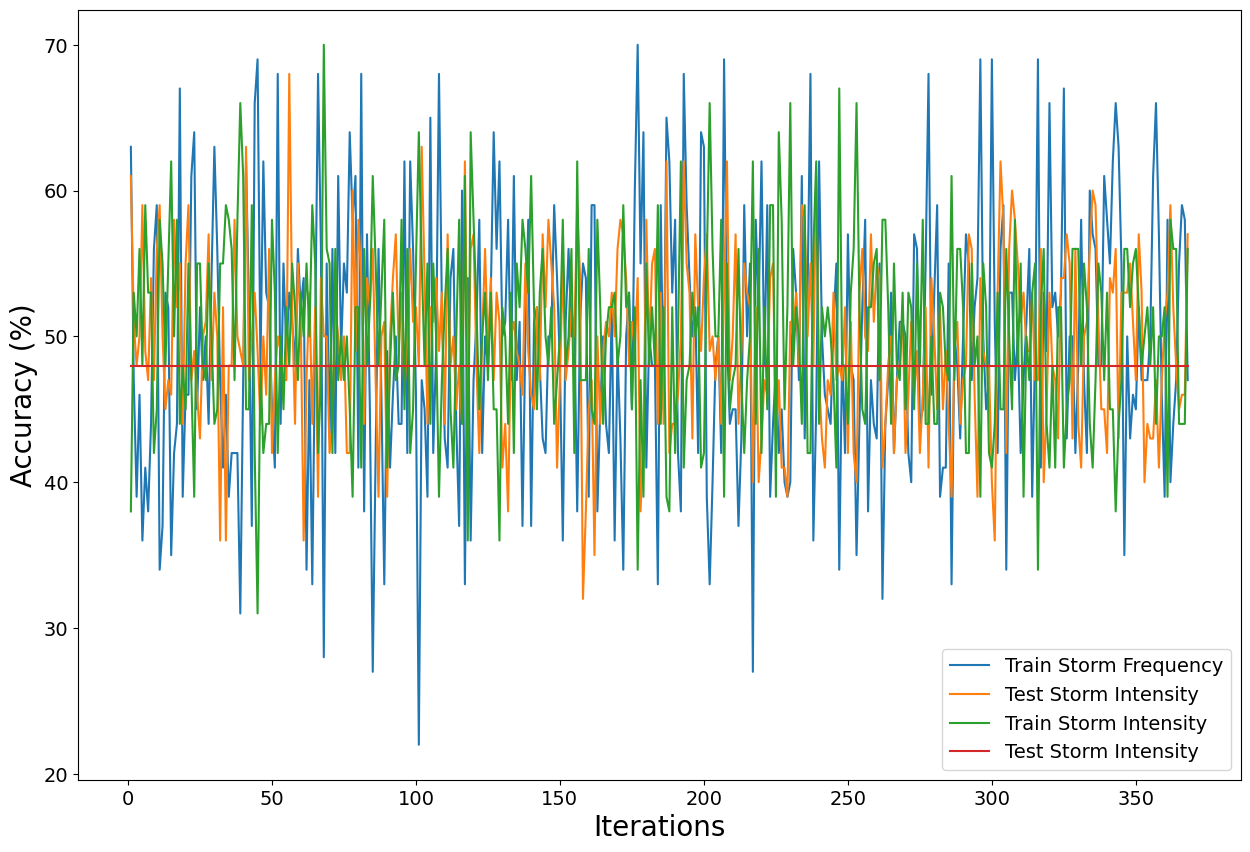

In [407]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, accuracy_list_train_freq, label="Train Storm Frequency")
plt.plot(iteration_list, accuracy_list_test_freq, label="Test Storm Intensity")
plt.plot(iteration_list, accuracy_list_train_intensity, label="Train Storm Intensity")
plt.plot(iteration_list, accuracy_list_test_intensity, label="Test Storm Intensity")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Accuracy (%)', fontsize = 20);
plt.legend(loc = 'best')

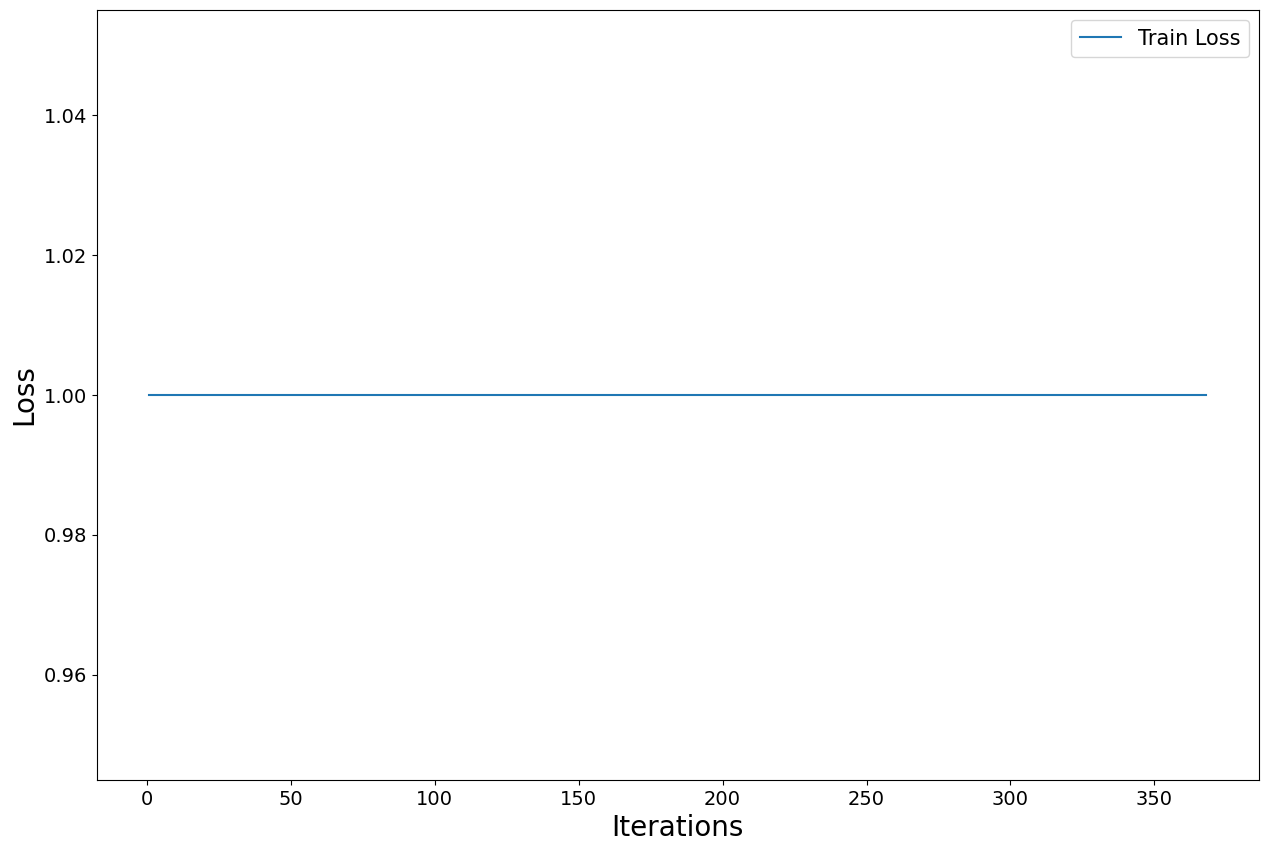

In [408]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, loss_list_train, label="Train Loss")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Loss', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

In [382]:
data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']].values

X_unseen_nn = torch.from_numpy(X_unseen_nn).float()
Y_unseen_nn = torch.from_numpy(Y_unseen_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
unseen_nn = TensorDataset(X_unseen_nn,Y_unseen_nn)

# data loader
unseen_nn = DataLoader(unseen_nn, batch_size = batch_size, shuffle = False, drop_last=True)

In [409]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in test_loader_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity test = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq test = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity test =  49.52174
accuracy freq test =  50.45652


In [410]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in unseen_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity unseen = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq unseen = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity unseen =  99.78571
accuracy freq unseen =  0.0


In [385]:
import os
current_dir = os.getcwd()
current_dir

'C:\\Users\\jkuhn\\Documents\\organized\\School\\Northwestern_Masters\\Capstone_Thesis'

In [411]:
# save model 1
torch.save(model.state_dict(), current_dir + r'\Models\LSTM_Decoder\LSTM_model5')

# LSTM Separated

In [222]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import imblearn
from imblearn.over_sampling import SMOTE

data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956

X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_nn = data_nn['tropical_storm_occurence'].values
X_nn, Y_nn = SMOTE().fit_resample(X_nn, Y_nn)
data_nn = pd.DataFrame(np.column_stack([X_nn,Y_nn]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_nn = data_nn[['tropical_storm_occurence','USA_SSHS']].values

X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X_nn, Y_nn, test_size = 0.2, random_state = 42) 

X_train_nn = torch.from_numpy(X_train_nn).float()
X_test_nn = torch.from_numpy(X_test_nn).float()
Y_train_nn = torch.from_numpy(Y_train_nn).type(torch.LongTensor).float()
Y_test_nn = torch.from_numpy(Y_test_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
train_nn = TensorDataset(X_train_nn,Y_train_nn)
test_nn = TensorDataset(X_test_nn,Y_test_nn)

# # batch_size, epoch and iteration
batch_size = 64
n_iters = 700
num_epochs = n_iters / (len(X_train_nn) / batch_size)

num_epochs = int(num_epochs)
print("Epoch Number: ",num_epochs)

# data loader
train_loader_nn = DataLoader(train_nn, batch_size = batch_size, shuffle = False, drop_last=True)
test_loader_nn = DataLoader(test_nn, batch_size = batch_size, shuffle = False, drop_last=True)

Epoch Number:  1


In [287]:
import torch
from torch import nn
import pytorch_lightning as pl

class X1_Output_LSTM(nn.Module):
    def __init__(self, lstm_size, output_dim):
        super().__init__()
        dense3 = nn.Linear(lstm_size, output_dim, bias=False)
        self.dense3 = nn.utils.weight_norm(dense3)
    def forward(self, x):
        x1 = nn.functional.sigmoid(self.dense3(x))
        return x1
    
class X2_Output_LSTM(nn.Module):
    def __init__(self, lstm_size, output_dim):
        super().__init__()
        dense3 = nn.Linear(lstm_size, output_dim, bias=False)
        self.dense3 = nn.utils.weight_norm(dense3)
    def forward(self, x):
        x2 = nn.functional.relu(self.dense3(x))
        return x2
    
class SoftOrdering1DCNN_LSTM(pl.LightningModule):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2, LSTM_option = False, LSTM_separate = False):
        super().__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        self.loss = nn.BCEWithLogitsLoss()

        self.first_dense = FirstDense(input_dim, dropout_input, sign_size, cha_input)
        self.x1_output_LSTM = X1_Output_LSTM(lstm_size=512, output_dim = output_dim)
        self.x2_output_LSTM = X2_Output_LSTM(lstm_size=512, output_dim = output_dim)
        
        self.LSTM_option = LSTM_option
        self.LSTM_separate = LSTM_separate
        self.lstm1 = nn.LSTMCell(256, 256)
        self.lstm2 = nn.LSTMCell(256, 256)
        self.lstm_separate = nn.LSTMCell(input_dim, 512)
        
    def forward(self, x):
        x_original = x
#         x = self.first_dense(x)
        if self.LSTM_option:
            x, _ = self.lstm1(x)
        elif self.LSTM_separate:
            x, _ = self.lstm_separate(x_original)
#             x = torch.cat([x, x_lstm], dim=1)
            x1 = self.x1_output_LSTM(x)
            x2 = self.x2_output_LSTM(x)
        else:
            x1 = self.x1_output(x)
            x2 = self.x2_output(x)
        
        return x1, x2


(dot.exe:18132): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


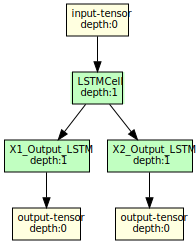

In [288]:
import graphviz
from torchview import draw_graph

model3 = SoftOrdering1DCNN_LSTM(input_dim=7, output_dim=1, sign_size=16, cha_input=32, cha_hidden=64, K=2,
                                dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2, LSTM_option = False, 
                                LSTM_separate = True)

for testpred, testtarget in test_loader_nn:
    testpred
    
model_graph = draw_graph(model3, input_size=testpred.shape, show_shapes = False, expand_nested=False, depth = 1)
model_graph.visual_graph #.render('model1', format = 'png')

In [259]:
%%time
from torchmetrics.classification import BinaryPrecision
model = SoftOrdering1DCNN_LSTM(input_dim=7, output_dim=1, sign_size=16, cha_input=32, cha_hidden=64, K=2,
                         dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2, LSTM_option = False,
                         LSTM_separate = True)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
error_multiple = nn.CrossEntropyLoss(); error_binary = nn.BCELoss()

loss_list_train = []; loss_list_test = []; iteration_list = []; accuracy_list_train_freq = []; accuracy_list_train_intensity = []
accuracy_list_test_freq = []; accuracy_list_test_intensity = []; count = 0

for epoch in range(num_epochs):
    for i, (predictors, targets) in enumerate(train_loader_nn):
        optimizer.zero_grad()
        outputs_freq, outputs_intensity = model(predictors)
        frequencies = torch.Tensor([item[0] for item in targets]).unsqueeze(1)
        intensities = torch.Tensor([item[1] for item in targets]).unsqueeze(1)
        
        loss_freq = error_binary(outputs_freq, frequencies); loss_intensity = error_multiple(outputs_intensity, intensities)
        
        total_train = frequencies.size(0)
        loss_hit = 0
        for idx, x in enumerate(frequencies):
            if x == 1:
                loss_hit += x - outputs_freq[idx]
        correct_train_intensity = (torch.round(outputs_intensity) == intensities).sum()
        metric = BinaryPrecision()
        accuracy_train_freq = metric(torch.round(outputs_freq), frequencies)
        accuracy_train_freq = torch.round(100*accuracy_train_freq)
        accuracy_train_intensity = torch.round(100 * correct_train_intensity/total_train)
        loss_total = loss_freq + loss_intensity #+ loss_hit*0.1
        loss_total = torch.round(loss_total)
        loss_total.backward()
        optimizer.step()
        count += 1
        
        for testpred, testtarget in test_loader_nn:
            test_freq_pred, test_intensity_pred = model(testpred)
            test_freq = torch.Tensor([item[0] for item in testtarget]).unsqueeze(1)
            test_intensity = torch.Tensor([item[1] for item in testtarget]).unsqueeze(1)
            loss_freq_test = error_binary(test_freq_pred, test_freq); 
            loss_intensity_test = error_multiple(test_intensity_pred, test_intensity)
            loss_total_test = torch.round(loss_freq_test + loss_intensity_test)
            loss_hit_test = 0
            for idxtest, xtest in enumerate(test_freq):
                if xtest == 1:
                    loss_hit_test += xtest - test_freq_pred[idxtest]
            total_test = test_freq.size(0)
            correct_test_intensity = (torch.round(test_intensity_pred) == test_intensity).sum()
            accuracy_test_freq = metric(torch.round(test_freq_pred), test_freq)
            accuracy_test_freq = torch.round(100*accuracy_test_freq)
            accuracy_test_intensity = torch.round(100 * correct_test_intensity/total_test)
        
        loss_list_train.append(loss_total.data.item())
        iteration_list.append(count)
        accuracy_list_train_freq.append(accuracy_train_freq)
        accuracy_list_train_intensity.append(accuracy_train_intensity)
        accuracy_list_test_freq.append(accuracy_test_freq)
        accuracy_list_test_intensity.append(accuracy_test_intensity)
        print('Iteration: {}. Loss_train_freq: {}. Accuracy_train_freq: {}. Accuracy_train_intensity: {}. Accuracy_test_freq: {}. Accuracy_test_intensity: {}.'\
              .format(count, loss_total.data.item(), accuracy_train_freq, accuracy_train_intensity, accuracy_test_freq, accuracy_test_intensity))

Iteration: 1. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 2. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 53.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 3. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 4. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 5. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 6. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 59.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 7. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 53.0. Accura

Iteration: 56. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 57. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 55.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 58. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 59. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 60. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 53.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 61. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 62. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 55.0.

Iteration: 111. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 112. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 113. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 114. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 115. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 58.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 116. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 117. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity

Iteration: 165. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 166. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 167. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 168. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 169. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 53.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 170. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 171. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity

Iteration: 219. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 220. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 221. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 222. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 223. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 59.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 224. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 59.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 225. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity

Iteration: 273. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 274. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 55.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 275. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 276. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 58.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 277. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 278. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 279. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity

Iteration: 327. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 328. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 329. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 330. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 56.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 331. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 332. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity: 55.0. Accuracy_test_freq: 0.0. Accuracy_test_intensity: 48.0.
Iteration: 333. Loss_train_freq: 1.0. Accuracy_train_freq: 0.0. Accuracy_train_intensity

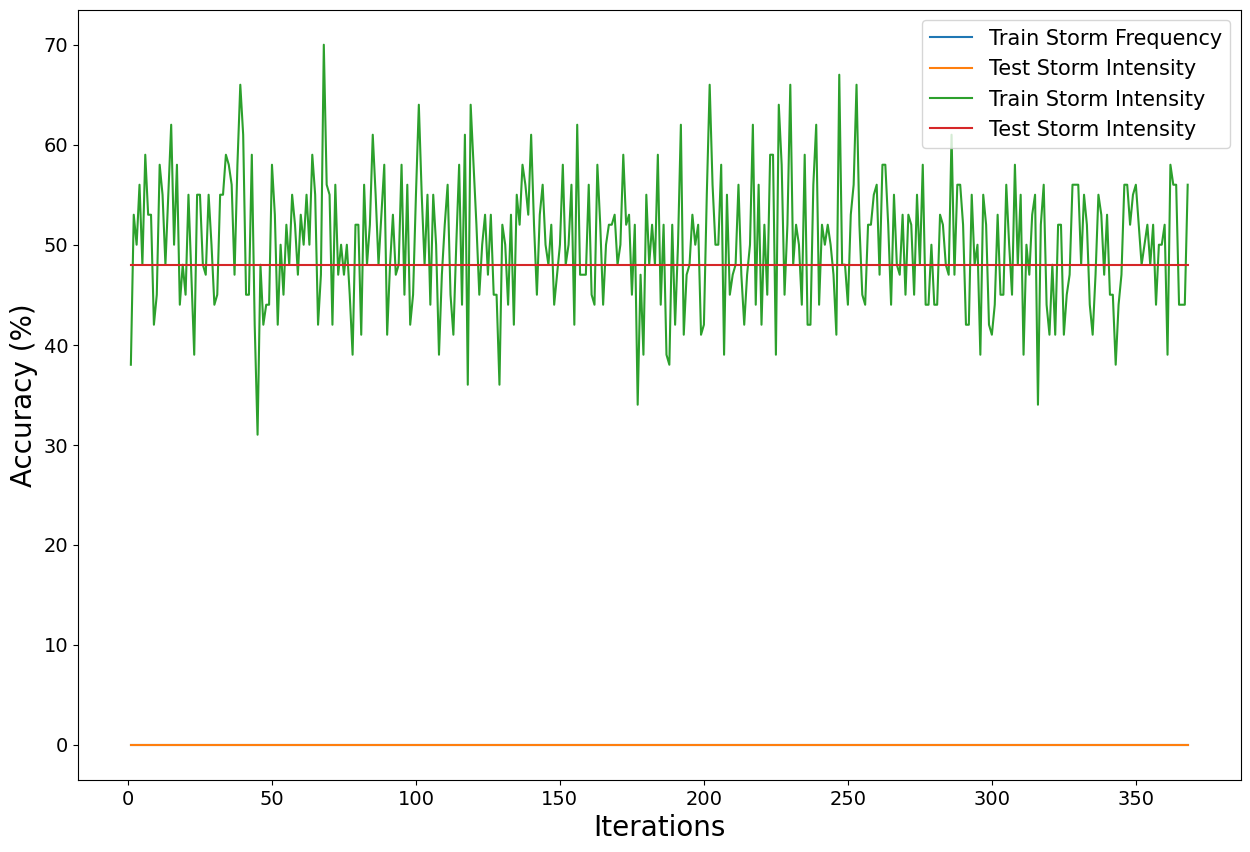

In [260]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, accuracy_list_train_freq, label="Train Storm Frequency")
plt.plot(iteration_list, accuracy_list_test_freq, label="Test Storm Intensity")
plt.plot(iteration_list, accuracy_list_train_intensity, label="Train Storm Intensity")
plt.plot(iteration_list, accuracy_list_test_intensity, label="Test Storm Intensity")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Accuracy (%)', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

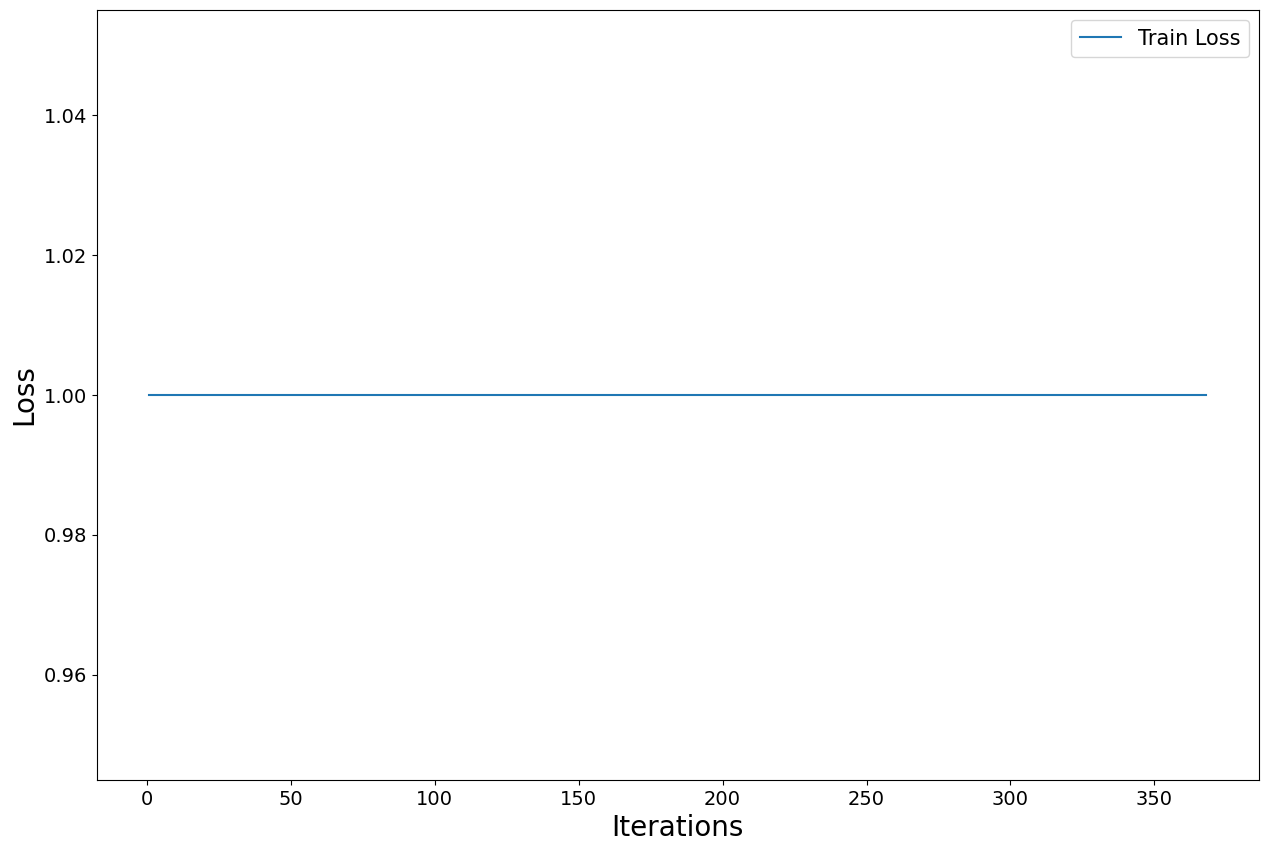

In [261]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, loss_list_train, label="Train Loss")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Loss', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

In [243]:
data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']].values

X_unseen_nn = torch.from_numpy(X_unseen_nn).float()
Y_unseen_nn = torch.from_numpy(Y_unseen_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
unseen_nn = TensorDataset(X_unseen_nn,Y_unseen_nn)

# data loader
unseen_nn = DataLoader(unseen_nn, batch_size = batch_size, shuffle = False, drop_last=True)

In [262]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in test_loader_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity test = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq test = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity test =  49.52174
accuracy freq test =  0.0


In [263]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in unseen_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity unseen = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq unseen = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity unseen =  99.78571
accuracy freq unseen =  0.0


In [238]:
import os
current_dir = os.getcwd()
current_dir

'C:\\Users\\jkuhn\\Documents\\organized\\School\\Northwestern_Masters\\Capstone_Thesis'

In [264]:
# save model 1
torch.save(model.state_dict(), current_dir + r'\Models\LSTM_Separated\LSTM_model5')

# CNN + LSTM separate models

In [289]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import imblearn
from imblearn.over_sampling import SMOTE

data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956

X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_nn = data_nn['tropical_storm_occurence'].values
X_nn, Y_nn = SMOTE().fit_resample(X_nn, Y_nn)
data_nn = pd.DataFrame(np.column_stack([X_nn,Y_nn]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_nn = data_nn[['tropical_storm_occurence','USA_SSHS']].values

X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X_nn, Y_nn, test_size = 0.2, random_state = 42) 

X_train_nn = torch.from_numpy(X_train_nn).float()
X_test_nn = torch.from_numpy(X_test_nn).float()
Y_train_nn = torch.from_numpy(Y_train_nn).type(torch.LongTensor).float()
Y_test_nn = torch.from_numpy(Y_test_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
train_nn = TensorDataset(X_train_nn,Y_train_nn)
test_nn = TensorDataset(X_test_nn,Y_test_nn)

# # batch_size, epoch and iteration
batch_size = 64
n_iters = 700
num_epochs = n_iters / (len(X_train_nn) / batch_size)

num_epochs = int(num_epochs)
print("Epoch Number: ",num_epochs)

# data loader
train_loader_nn = DataLoader(train_nn, batch_size = batch_size, shuffle = False, drop_last=True)
test_loader_nn = DataLoader(test_nn, batch_size = batch_size, shuffle = False, drop_last=True)

Epoch Number:  1


In [290]:
data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']].values

X_unseen_nn = torch.from_numpy(X_unseen_nn).float()
Y_unseen_nn = torch.from_numpy(Y_unseen_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
unseen_nn = TensorDataset(X_unseen_nn,Y_unseen_nn)

# data loader
unseen_nn = DataLoader(unseen_nn, batch_size = batch_size, shuffle = False, drop_last=True)

In [291]:
import torch
from torch import nn
import pytorch_lightning as pl

class X1_Output(nn.Module):
    def __init__(self, sign_size, cha_hidden, output_dim):
        super().__init__()
        self.cha_hidden = cha_hidden
        output_size = (sign_size//4)*cha_hidden
        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)
    def forward(self, x):
        x1 = nn.functional.sigmoid(self.dense2(x))
        return x1

class X1_Output_LSTM(nn.Module):
    def __init__(self, lstm_size, output_dim):
        super().__init__()
        dense3 = nn.Linear(lstm_size, output_dim, bias=False)
        self.dense3 = nn.utils.weight_norm(dense3)
    def forward(self, x):
        x1 = nn.functional.sigmoid(self.dense3(x))
        return x1
    
class X2_Output(nn.Module):
    def __init__(self, sign_size, cha_hidden, output_dim):
        super().__init__()
        self.cha_hidden = cha_hidden
        output_size = (sign_size//4)*cha_hidden
        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)
    def forward(self, x):
        x2 = nn.functional.relu(self.dense2(x))
        return x2

class X2_Output_LSTM(nn.Module):
    def __init__(self, lstm_size, output_dim):
        super().__init__()
        dense3 = nn.Linear(lstm_size, output_dim, bias=False)
        self.dense3 = nn.utils.weight_norm(dense3)
    def forward(self, x):
        x2 = nn.functional.relu(self.dense3(x))
        return x2
    
class SoftOrdering1DCNN_LSTM(pl.LightningModule):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2, LSTM_option = False, LSTM_separate = False):
        super().__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        self.loss = nn.BCEWithLogitsLoss()

        self.first_dense = FirstDense(input_dim, dropout_input, sign_size, cha_input)
        self.first_and_second_conv = First_and_Second_Conv(cha_input, K, sign_size, dropout_hidden, cha_hidden)
        self.third_and_fourth_conv = Third_and_Fourth_Conv(cha_hidden, dropout_hidden)
        self.flatten_batchNorm_dropout = Flatten_BatchNorm_Dropout(sign_size, cha_hidden, dropout_output)
        self.x1_output = X1_Output(sign_size, cha_hidden, output_dim)
        self.x2_output = X2_Output(sign_size, cha_hidden, output_dim)
        self.x1_output_LSTM = X1_Output_LSTM(lstm_size=512, output_dim = output_dim)
        self.x2_output_LSTM = X2_Output_LSTM(lstm_size=512, output_dim = output_dim)
        
        self.LSTM_option = LSTM_option
        self.LSTM_separate = LSTM_separate
        self.lstm1 = nn.LSTMCell(256, 256)
        self.lstm2 = nn.LSTMCell(256, 256)
        self.lstm_separate = nn.LSTMCell(input_dim, 256) #nn.LSTMCell(input_dim, 256)
        
    def forward(self, x):
        x_original = x
        x = self.first_dense(x)
        x = self.first_and_second_conv(x)
        x_s = x
        x = self.third_and_fourth_conv(x)

        x = self.flatten_batchNorm_dropout(x, x_s)
        
        if self.LSTM_option:
            x, _ = self.lstm1(x)
        elif self.LSTM_separate:
            x_lstm, _ = self.lstm_separate(x_original)
            x = torch.cat([x, x_lstm], dim=1)
            x1 = self.x1_output_LSTM(x)
            x2 = self.x2_output_LSTM(x)
        else:
            x1 = self.x1_output(x)
            x2 = self.x2_output(x)
        
        return x1, x2


(dot.exe:1400): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


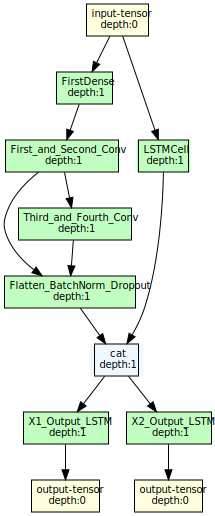

In [292]:
import graphviz
from torchview import draw_graph

model3 = SoftOrdering1DCNN_LSTM(input_dim=7, output_dim=1, sign_size=16, cha_input=32, cha_hidden=64, K=2,
                                dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2, LSTM_option = False, 
                                LSTM_separate = True)

for testpred, testtarget in test_loader_nn:
    testpred
    
model_graph = draw_graph(model3, input_size=testpred.shape, show_shapes = False, expand_nested=False, depth = 1)
model_graph.visual_graph #.render('model1', format = 'png')

In [321]:
%%time
from torchmetrics.classification import BinaryPrecision
model = SoftOrdering1DCNN_LSTM(input_dim=7, output_dim=1, sign_size=16, cha_input=32, cha_hidden=64, K=2,
                         dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2, LSTM_option = False,
                         LSTM_separate = True)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
error_multiple = nn.CrossEntropyLoss(); error_binary = nn.BCELoss()

loss_list_train = []; loss_list_test = []; iteration_list = []; accuracy_list_train_freq = []; accuracy_list_train_intensity = []
accuracy_list_test_freq = []; accuracy_list_test_intensity = []; count = 0

for epoch in range(num_epochs):
    for i, (predictors, targets) in enumerate(train_loader_nn):
        optimizer.zero_grad()
        outputs_freq, outputs_intensity = model(predictors)
        frequencies = torch.Tensor([item[0] for item in targets]).unsqueeze(1)
        intensities = torch.Tensor([item[1] for item in targets]).unsqueeze(1)
        
        loss_freq = error_binary(outputs_freq, frequencies); loss_intensity = error_multiple(outputs_intensity, intensities)
        
        total_train = frequencies.size(0)
        loss_hit = 0
        for idx, x in enumerate(frequencies):
            if x == 1:
                loss_hit += x - outputs_freq[idx]
        correct_train_intensity = (torch.round(outputs_intensity) == intensities).sum()
        metric = BinaryPrecision()
        accuracy_train_freq = metric(torch.round(outputs_freq), frequencies)
        accuracy_train_freq = torch.round(100*accuracy_train_freq)
        accuracy_train_intensity = torch.round(100 * correct_train_intensity/total_train)
        loss_total = loss_freq + loss_intensity #+ loss_hit*0.1
        loss_total = torch.round(loss_total)
        loss_total.backward()
        optimizer.step()
        count += 1
        
        for testpred, testtarget in test_loader_nn:
            test_freq_pred, test_intensity_pred = model(testpred)
            test_freq = torch.Tensor([item[0] for item in testtarget]).unsqueeze(1)
            test_intensity = torch.Tensor([item[1] for item in testtarget]).unsqueeze(1)
            loss_freq_test = error_binary(test_freq_pred, test_freq); 
            loss_intensity_test = error_multiple(test_intensity_pred, test_intensity)
            loss_total_test = torch.round(loss_freq_test + loss_intensity_test)
            loss_hit_test = 0
            for idxtest, xtest in enumerate(test_freq):
                if xtest == 1:
                    loss_hit_test += xtest - test_freq_pred[idxtest]
            total_test = test_freq.size(0)
            correct_test_intensity = (torch.round(test_intensity_pred) == test_intensity).sum()
            accuracy_test_freq = metric(torch.round(test_freq_pred), test_freq)
            accuracy_test_freq = torch.round(100*accuracy_test_freq)
            accuracy_test_intensity = torch.round(100 * correct_test_intensity/total_test)
        
        loss_list_train.append(loss_total.data.item())
        iteration_list.append(count)
        accuracy_list_train_freq.append(accuracy_train_freq)
        accuracy_list_train_intensity.append(accuracy_train_intensity)
        accuracy_list_test_freq.append(accuracy_test_freq)
        accuracy_list_test_intensity.append(accuracy_test_intensity)
        print('Iteration: {}. Loss_train_freq: {}. Accuracy_train_freq: {}. Accuracy_train_intensity: {}. Accuracy_test_freq: {}. Accuracy_test_intensity: {}.'\
              .format(count, loss_total.data.item(), accuracy_train_freq, accuracy_train_intensity, accuracy_test_freq, accuracy_test_intensity))

Iteration: 1. Loss_train_freq: 1.0. Accuracy_train_freq: 67.0. Accuracy_train_intensity: 30.0. Accuracy_test_freq: 39.0. Accuracy_test_intensity: 45.0.
Iteration: 2. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 47.0. Accuracy_test_intensity: 41.0.
Iteration: 3. Loss_train_freq: 1.0. Accuracy_train_freq: 68.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 44.0. Accuracy_test_intensity: 45.0.
Iteration: 4. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 60.0. Accuracy_test_intensity: 48.0.
Iteration: 5. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 39.0.
Iteration: 6. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 47.0. Accuracy_test_intensity: 44.0.
Iteration: 7. Loss_train_freq: 1.0. Accuracy_train_freq: 40.0. Accuracy_train_intensity:

Iteration: 55. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 42.0.
Iteration: 56. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 44.0.
Iteration: 57. Loss_train_freq: 1.0. Accuracy_train_freq: 53.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 41.0.
Iteration: 58. Loss_train_freq: 1.0. Accuracy_train_freq: 36.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 42.0.
Iteration: 59. Loss_train_freq: 1.0. Accuracy_train_freq: 53.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 41.0. Accuracy_test_intensity: 45.0.
Iteration: 60. Loss_train_freq: 1.0. Accuracy_train_freq: 37.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 42.0. Accuracy_test_intensity: 39.0.
Iteration: 61. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_int

Iteration: 109. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 46.0. Accuracy_test_intensity: 44.0.
Iteration: 110. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 39.0. Accuracy_test_intensity: 44.0.
Iteration: 111. Loss_train_freq: 1.0. Accuracy_train_freq: 40.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 41.0.
Iteration: 112. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 40.0. Accuracy_test_intensity: 47.0.
Iteration: 113. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 36.0. Accuracy_test_freq: 63.0. Accuracy_test_intensity: 42.0.
Iteration: 114. Loss_train_freq: 1.0. Accuracy_train_freq: 39.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 40.0. Accuracy_test_intensity: 44.0.
Iteration: 115. Loss_train_freq: 1.0. Accuracy_train_freq: 37.0. Accuracy_tr

Iteration: 163. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 44.0.
Iteration: 164. Loss_train_freq: 1.0. Accuracy_train_freq: 57.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 29.0. Accuracy_test_intensity: 44.0.
Iteration: 165. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 35.0. Accuracy_test_intensity: 38.0.
Iteration: 166. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 44.0.
Iteration: 167. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 39.0. Accuracy_test_intensity: 45.0.
Iteration: 168. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 26.0. Accuracy_test_intensity: 45.0.
Iteration: 169. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_tr

Iteration: 217. Loss_train_freq: 1.0. Accuracy_train_freq: 56.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 42.0.
Iteration: 218. Loss_train_freq: 1.0. Accuracy_train_freq: 43.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 42.0. Accuracy_test_intensity: 44.0.
Iteration: 219. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 42.0. Accuracy_test_intensity: 45.0.
Iteration: 220. Loss_train_freq: 1.0. Accuracy_train_freq: 43.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 47.0. Accuracy_test_intensity: 44.0.
Iteration: 221. Loss_train_freq: 1.0. Accuracy_train_freq: 47.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 43.0. Accuracy_test_intensity: 44.0.
Iteration: 222. Loss_train_freq: 1.0. Accuracy_train_freq: 71.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 45.0.
Iteration: 223. Loss_train_freq: 1.0. Accuracy_train_freq: 41.0. Accuracy_tr

Iteration: 271. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 62.0. Accuracy_test_intensity: 42.0.
Iteration: 272. Loss_train_freq: 1.0. Accuracy_train_freq: 45.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 42.0. Accuracy_test_intensity: 42.0.
Iteration: 273. Loss_train_freq: 1.0. Accuracy_train_freq: 68.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 47.0. Accuracy_test_intensity: 42.0.
Iteration: 274. Loss_train_freq: 1.0. Accuracy_train_freq: 57.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 48.0. Accuracy_test_intensity: 42.0.
Iteration: 275. Loss_train_freq: 1.0. Accuracy_train_freq: 46.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 22.0. Accuracy_test_intensity: 45.0.
Iteration: 276. Loss_train_freq: 1.0. Accuracy_train_freq: 35.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 44.0.
Iteration: 277. Loss_train_freq: 1.0. Accuracy_train_freq: 67.0. Accuracy_tr

Iteration: 325. Loss_train_freq: 1.0. Accuracy_train_freq: 61.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 50.0. Accuracy_test_intensity: 36.0.
Iteration: 326. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 40.0. Accuracy_test_intensity: 41.0.
Iteration: 327. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 30.0. Accuracy_test_intensity: 45.0.
Iteration: 328. Loss_train_freq: 1.0. Accuracy_train_freq: 43.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 34.0.
Iteration: 329. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 65.0. Accuracy_test_intensity: 41.0.
Iteration: 330. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 44.0.
Iteration: 331. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_tr

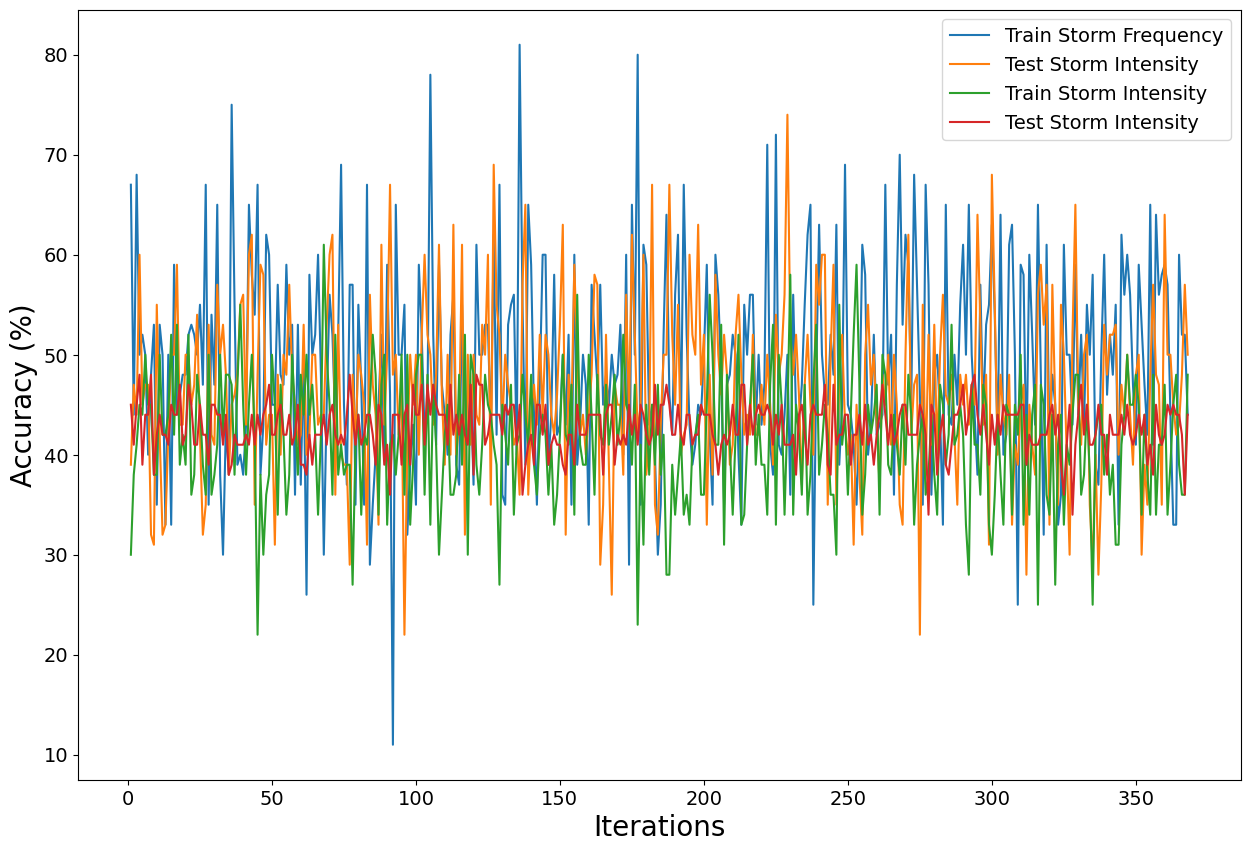

In [322]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, accuracy_list_train_freq, label="Train Storm Frequency")
plt.plot(iteration_list, accuracy_list_test_freq, label="Test Storm Intensity")
plt.plot(iteration_list, accuracy_list_train_intensity, label="Train Storm Intensity")
plt.plot(iteration_list, accuracy_list_test_intensity, label="Test Storm Intensity")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Accuracy (%)', fontsize = 20);
plt.legend(loc = 'best')

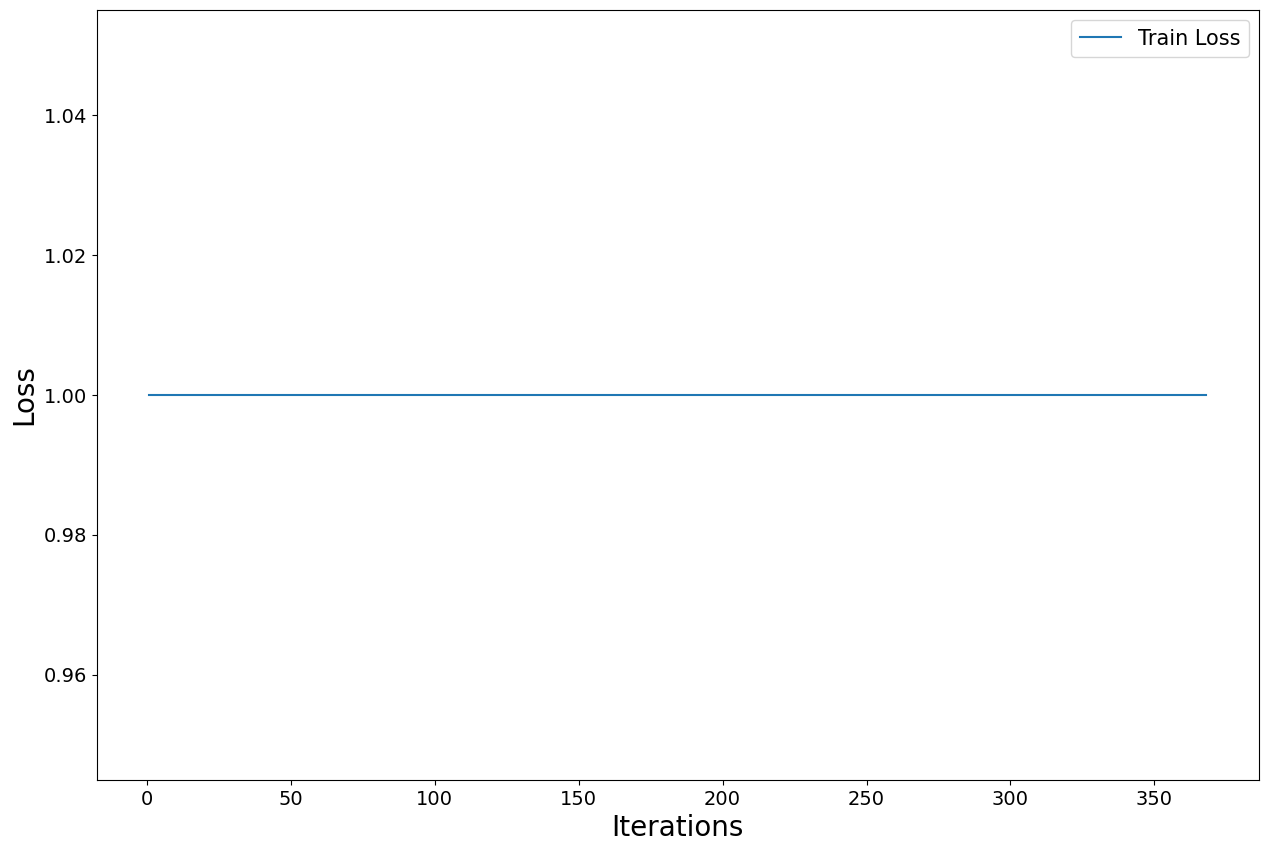

In [323]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, loss_list_train, label="Train Loss")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Loss', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

In [324]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in test_loader_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity test = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq test = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity test =  41.260868
accuracy freq test =  48.869564


In [325]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in unseen_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity unseen = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq unseen = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity unseen =  87.07143
accuracy freq unseen =  0.2857143


In [326]:
# save model 1
torch.save(model.state_dict(), current_dir + r'\Models\CNN_LSTM_separate\model5')

# CNN + LSTM + PINN

In [460]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import imblearn
from imblearn.over_sampling import SMOTE

data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956

X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_nn = data_nn['tropical_storm_occurence'].values
X_nn, Y_nn = SMOTE().fit_resample(X_nn, Y_nn)
data_nn = pd.DataFrame(np.column_stack([X_nn,Y_nn]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_nn = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_nn = data_nn[['tropical_storm_occurence','USA_SSHS']].values

X_train_nn, X_test_nn, Y_train_nn, Y_test_nn = train_test_split(X_nn, Y_nn, test_size = 0.2, random_state = 42) 

X_train_nn = torch.from_numpy(X_train_nn).float()
X_test_nn = torch.from_numpy(X_test_nn).float()
Y_train_nn = torch.from_numpy(Y_train_nn).type(torch.LongTensor).float()
Y_test_nn = torch.from_numpy(Y_test_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
train_nn = TensorDataset(X_train_nn,Y_train_nn)
test_nn = TensorDataset(X_test_nn,Y_test_nn)

# # batch_size, epoch and iteration
batch_size = 64
n_iters = 700
num_epochs = n_iters / (len(X_train_nn) / batch_size)

num_epochs = int(num_epochs)
print("Epoch Number: ",num_epochs)

# data loader
train_loader_nn = DataLoader(train_nn, batch_size = batch_size, shuffle = False, drop_last=True)
test_loader_nn = DataLoader(test_nn, batch_size = batch_size, shuffle = False, drop_last=True)

Epoch Number:  1


In [461]:
data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']].values
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']].values

X_unseen_nn = torch.from_numpy(X_unseen_nn).float()
Y_unseen_nn = torch.from_numpy(Y_unseen_nn).type(torch.LongTensor).float()

# # Pytorch train and test sets
unseen_nn = TensorDataset(X_unseen_nn,Y_unseen_nn)

# data loader
unseen_nn = DataLoader(unseen_nn, batch_size = batch_size, shuffle = False, drop_last=True)

In [487]:
%%time
from torchmetrics.classification import BinaryPrecision
model = SoftOrdering1DCNN_LSTM(input_dim=7, output_dim=1, sign_size=16, cha_input=32, cha_hidden=64, K=2,
                         dropout_input = 0.3, dropout_hidden = 0.3, dropout_output = 0.2, LSTM_option = False,
                         LSTM_separate = True)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
error_multiple = nn.CrossEntropyLoss(); error_binary = nn.BCELoss()

loss_list_train = []; loss_list_test = []; iteration_list = []; accuracy_list_train_freq = []; accuracy_list_train_intensity = []
accuracy_list_test_freq = []; accuracy_list_test_intensity = []; count = 0

for epoch in range(num_epochs):
    for i, (predictors, targets) in enumerate(train_loader_nn):
        optimizer.zero_grad()
        outputs_freq, outputs_intensity = model(predictors)
        frequencies = torch.Tensor([item[0] for item in targets]).unsqueeze(1)
        intensities = torch.Tensor([item[1] for item in targets]).unsqueeze(1)
        
        loss_freq = error_binary(outputs_freq, frequencies); loss_intensity = error_multiple(outputs_intensity, intensities)
        
        total_train = frequencies.size(0)
        loss_pinn = 0
        for idx, l in enumerate(outputs_intensity):
            if torch.round(l) >= 4 and torch.round(outputs_freq[idx]) != 1:
                loss_pinn += 1
                
        correct_train_intensity = (torch.round(outputs_intensity) == intensities).sum()
        metric = BinaryPrecision()
        accuracy_train_freq = metric(torch.round(outputs_freq), frequencies)
        accuracy_train_freq = torch.round(100*accuracy_train_freq)
        accuracy_train_intensity = torch.round(100 * correct_train_intensity/total_train)
        loss_total = loss_freq + loss_intensity + loss_pinn #+ loss_hit*0.1
        loss_total = torch.round(loss_total)
        loss_total.backward()
        optimizer.step()
        count += 1
        
        for testpred, testtarget in test_loader_nn:
            test_freq_pred, test_intensity_pred = model(testpred)
            test_freq = torch.Tensor([item[0] for item in testtarget]).unsqueeze(1)
            test_intensity = torch.Tensor([item[1] for item in testtarget]).unsqueeze(1)
            loss_freq_test = error_binary(test_freq_pred, test_freq); 
            loss_intensity_test = error_multiple(test_intensity_pred, test_intensity)
            loss_total_test = torch.round(loss_freq_test + loss_intensity_test)
            loss_hit_test = 0
            for idxtest, xtest in enumerate(test_freq):
                if xtest == 1:
                    loss_hit_test += xtest - test_freq_pred[idxtest]
            total_test = test_freq.size(0)
            correct_test_intensity = (torch.round(test_intensity_pred) == test_intensity).sum()
            accuracy_test_freq = metric(torch.round(test_freq_pred), test_freq)
            accuracy_test_freq = torch.round(100*accuracy_test_freq)
            accuracy_test_intensity = torch.round(100 * correct_test_intensity/total_test)
        
        loss_list_train.append(loss_total.data.item())
        iteration_list.append(count)
        accuracy_list_train_freq.append(accuracy_train_freq)
        accuracy_list_train_intensity.append(accuracy_train_intensity)
        accuracy_list_test_freq.append(accuracy_test_freq)
        accuracy_list_test_intensity.append(accuracy_test_intensity)
        print('Iteration: {}. Loss_train_freq: {}. Accuracy_train_freq: {}. Accuracy_train_intensity: {}. Accuracy_test_freq: {}. Accuracy_test_intensity: {}.'\
              .format(count, loss_total.data.item(), accuracy_train_freq, accuracy_train_intensity, accuracy_test_freq, accuracy_test_intensity))

Iteration: 1. Loss_train_freq: 1.0. Accuracy_train_freq: 74.0. Accuracy_train_intensity: 34.0. Accuracy_test_freq: 68.0. Accuracy_test_intensity: 45.0.
Iteration: 2. Loss_train_freq: 1.0. Accuracy_train_freq: 71.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 45.0.
Iteration: 3. Loss_train_freq: 1.0. Accuracy_train_freq: 71.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 70.0. Accuracy_test_intensity: 47.0.
Iteration: 4. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 67.0. Accuracy_test_intensity: 44.0.
Iteration: 5. Loss_train_freq: 1.0. Accuracy_train_freq: 71.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 67.0. Accuracy_test_intensity: 45.0.
Iteration: 6. Loss_train_freq: 1.0. Accuracy_train_freq: 59.0. Accuracy_train_intensity: 53.0. Accuracy_test_freq: 61.0. Accuracy_test_intensity: 44.0.
Iteration: 7. Loss_train_freq: 1.0. Accuracy_train_freq: 61.0. Accuracy_train_intensity:

Iteration: 55. Loss_train_freq: 1.0. Accuracy_train_freq: 54.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 57.0. Accuracy_test_intensity: 44.0.
Iteration: 56. Loss_train_freq: 1.0. Accuracy_train_freq: 63.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 64.0. Accuracy_test_intensity: 41.0.
Iteration: 57. Loss_train_freq: 1.0. Accuracy_train_freq: 64.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 75.0. Accuracy_test_intensity: 44.0.
Iteration: 58. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 60.0. Accuracy_test_intensity: 47.0.
Iteration: 59. Loss_train_freq: 1.0. Accuracy_train_freq: 80.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 67.0. Accuracy_test_intensity: 45.0.
Iteration: 60. Loss_train_freq: 1.0. Accuracy_train_freq: 76.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 70.0. Accuracy_test_intensity: 45.0.
Iteration: 61. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_int

Iteration: 109. Loss_train_freq: 1.0. Accuracy_train_freq: 83.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 54.0. Accuracy_test_intensity: 44.0.
Iteration: 110. Loss_train_freq: 1.0. Accuracy_train_freq: 71.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 72.0. Accuracy_test_intensity: 44.0.
Iteration: 111. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 66.0. Accuracy_test_intensity: 44.0.
Iteration: 112. Loss_train_freq: 1.0. Accuracy_train_freq: 70.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 65.0. Accuracy_test_intensity: 52.0.
Iteration: 113. Loss_train_freq: 1.0. Accuracy_train_freq: 82.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 67.0. Accuracy_test_intensity: 42.0.
Iteration: 114. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 45.0. Accuracy_test_freq: 67.0. Accuracy_test_intensity: 42.0.
Iteration: 115. Loss_train_freq: 1.0. Accuracy_train_freq: 46.0. Accuracy_tr

Iteration: 163. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 69.0. Accuracy_test_intensity: 38.0.
Iteration: 164. Loss_train_freq: 1.0. Accuracy_train_freq: 68.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 62.0. Accuracy_test_intensity: 44.0.
Iteration: 165. Loss_train_freq: 1.0. Accuracy_train_freq: 77.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 67.0. Accuracy_test_intensity: 47.0.
Iteration: 166. Loss_train_freq: 1.0. Accuracy_train_freq: 68.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 64.0. Accuracy_test_intensity: 42.0.
Iteration: 167. Loss_train_freq: 1.0. Accuracy_train_freq: 64.0. Accuracy_train_intensity: 48.0. Accuracy_test_freq: 76.0. Accuracy_test_intensity: 47.0.
Iteration: 168. Loss_train_freq: 1.0. Accuracy_train_freq: 77.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 73.0. Accuracy_test_intensity: 42.0.
Iteration: 169. Loss_train_freq: 1.0. Accuracy_train_freq: 55.0. Accuracy_tr

Iteration: 217. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_train_intensity: 55.0. Accuracy_test_freq: 55.0. Accuracy_test_intensity: 45.0.
Iteration: 218. Loss_train_freq: 1.0. Accuracy_train_freq: 83.0. Accuracy_train_intensity: 41.0. Accuracy_test_freq: 52.0. Accuracy_test_intensity: 39.0.
Iteration: 219. Loss_train_freq: 1.0. Accuracy_train_freq: 48.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 78.0. Accuracy_test_intensity: 44.0.
Iteration: 220. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 38.0. Accuracy_test_freq: 60.0. Accuracy_test_intensity: 47.0.
Iteration: 221. Loss_train_freq: 1.0. Accuracy_train_freq: 68.0. Accuracy_train_intensity: 50.0. Accuracy_test_freq: 61.0. Accuracy_test_intensity: 42.0.
Iteration: 222. Loss_train_freq: 1.0. Accuracy_train_freq: 78.0. Accuracy_train_intensity: 42.0. Accuracy_test_freq: 59.0. Accuracy_test_intensity: 47.0.
Iteration: 223. Loss_train_freq: 1.0. Accuracy_train_freq: 52.0. Accuracy_tr

Iteration: 271. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 72.0. Accuracy_test_intensity: 41.0.
Iteration: 272. Loss_train_freq: 1.0. Accuracy_train_freq: 79.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 56.0. Accuracy_test_intensity: 41.0.
Iteration: 273. Loss_train_freq: 1.0. Accuracy_train_freq: 62.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 63.0. Accuracy_test_intensity: 42.0.
Iteration: 274. Loss_train_freq: 1.0. Accuracy_train_freq: 75.0. Accuracy_train_intensity: 55.0. Accuracy_test_freq: 62.0. Accuracy_test_intensity: 41.0.
Iteration: 275. Loss_train_freq: 1.0. Accuracy_train_freq: 71.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 58.0. Accuracy_test_intensity: 48.0.
Iteration: 276. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 67.0. Accuracy_test_intensity: 41.0.
Iteration: 277. Loss_train_freq: 1.0. Accuracy_train_freq: 78.0. Accuracy_tr

Iteration: 325. Loss_train_freq: 1.0. Accuracy_train_freq: 88.0. Accuracy_train_intensity: 33.0. Accuracy_test_freq: 78.0. Accuracy_test_intensity: 45.0.
Iteration: 326. Loss_train_freq: 1.0. Accuracy_train_freq: 63.0. Accuracy_train_intensity: 39.0. Accuracy_test_freq: 70.0. Accuracy_test_intensity: 47.0.
Iteration: 327. Loss_train_freq: 1.0. Accuracy_train_freq: 70.0. Accuracy_train_intensity: 44.0. Accuracy_test_freq: 45.0. Accuracy_test_intensity: 39.0.
Iteration: 328. Loss_train_freq: 1.0. Accuracy_train_freq: 50.0. Accuracy_train_intensity: 52.0. Accuracy_test_freq: 69.0. Accuracy_test_intensity: 39.0.
Iteration: 329. Loss_train_freq: 1.0. Accuracy_train_freq: 65.0. Accuracy_train_intensity: 47.0. Accuracy_test_freq: 74.0. Accuracy_test_intensity: 47.0.
Iteration: 330. Loss_train_freq: 1.0. Accuracy_train_freq: 44.0. Accuracy_train_intensity: 53.0. Accuracy_test_freq: 72.0. Accuracy_test_intensity: 47.0.
Iteration: 331. Loss_train_freq: 1.0. Accuracy_train_freq: 72.0. Accuracy_tr

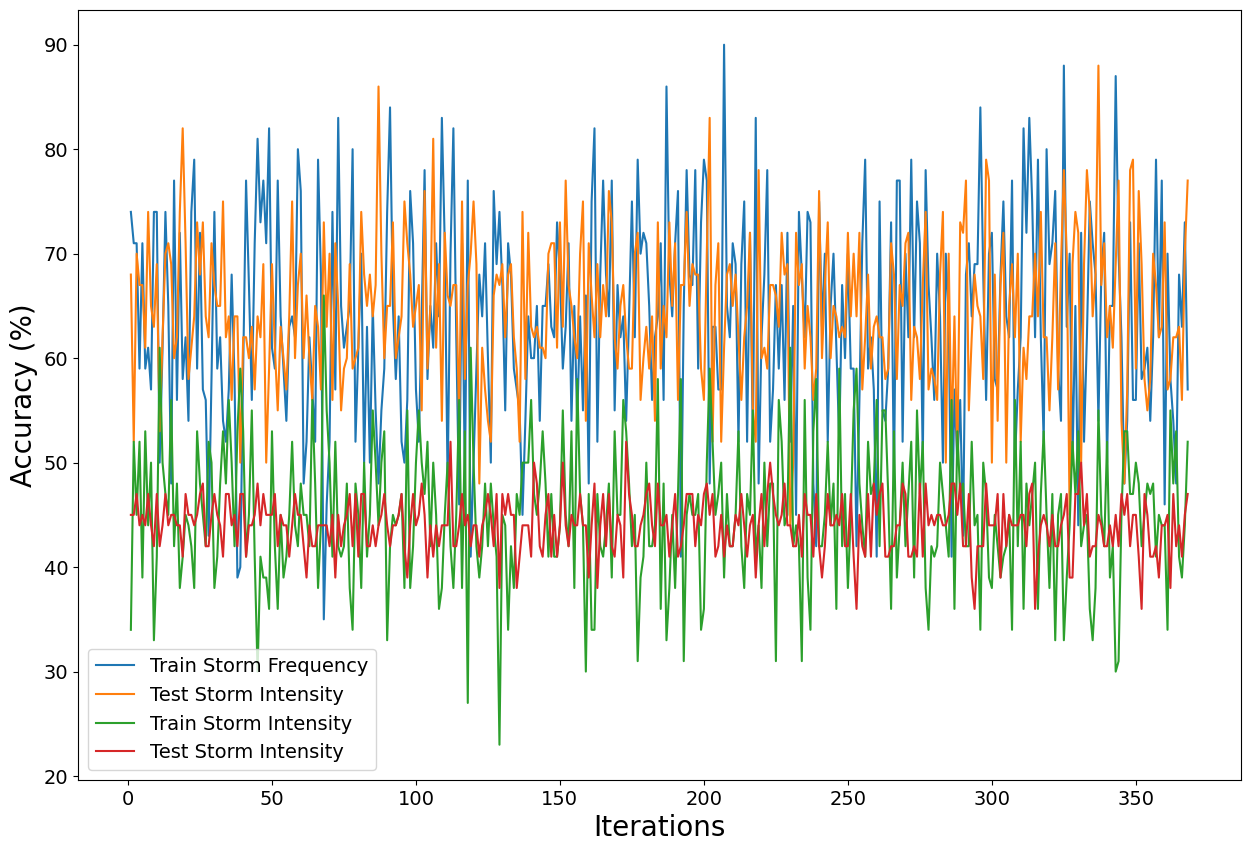

In [488]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, accuracy_list_train_freq, label="Train Storm Frequency")
plt.plot(iteration_list, accuracy_list_test_freq, label="Test Storm Intensity")
plt.plot(iteration_list, accuracy_list_train_intensity, label="Train Storm Intensity")
plt.plot(iteration_list, accuracy_list_test_intensity, label="Test Storm Intensity")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Accuracy (%)', fontsize = 20);
plt.legend(loc = 'best')

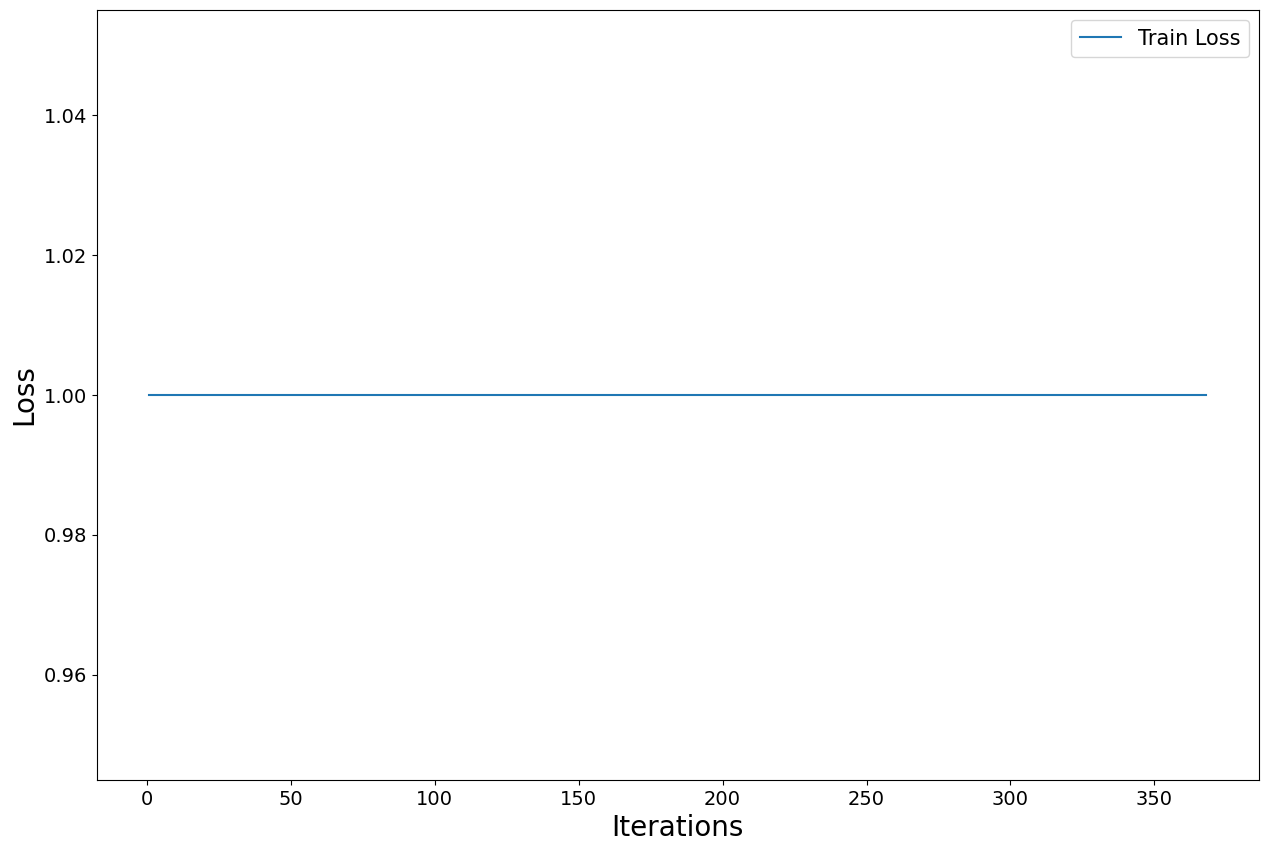

In [489]:
plt.figure(figsize = (15,10))
plt.plot(iteration_list, loss_list_train, label="Train Loss")
plt.xlabel('Iterations', fontsize = 20);
plt.ylabel('Loss', fontsize = 20);
plt.legend(loc = 'best', fontsize = 15)

In [490]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in test_loader_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity test = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq test = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity test =  45.391304
accuracy freq test =  64.45652


In [491]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in unseen_nn:
    unseen_freq_pred, unseen_intensity_pred = model(unseenpred)
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
    loss_freq_unseen = error_binary(unseen_freq_pred, unseen_freq); 
    loss_intensity_unseen = error_multiple(unseen_intensity_pred, unseen_intensity)
    loss_total_unseen = torch.round(loss_freq_unseen + loss_intensity_unseen)
    loss_hit_unseen = 0
    for idxunseen, xunseen in enumerate(unseen_freq):
        if xunseen == 1:
            loss_hit_unseen += xunseen - unseen_freq_pred[idxunseen]
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = metric(torch.round(unseen_freq_pred), unseen_freq)
    accuracy_unseen_freq = torch.round(100*accuracy_unseen_freq)
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity unseen = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq unseen = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity unseen =  88.35714
accuracy freq unseen =  0.21428572


In [492]:
# save model 1
torch.save(model.state_dict(), current_dir + r'\Models\CNN_LSTM_PINN\model5')

# XGBoost

In [665]:
from sklearn import ensemble
from sklearn.multioutput import MultiOutputRegressor

data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956
X_xg = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_xg = data_nn['tropical_storm_occurence'].values
X_xg, Y_xg = SMOTE().fit_resample(X_xg, Y_xg)
data_xg = pd.DataFrame(np.column_stack([X_xg,Y_xg]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_xg = data_xg[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']]
Y_xg = data_xg[['tropical_storm_occurence','USA_SSHS']]

X_train, X_test, Y_train, Y_test = train_test_split(X_xg, Y_xg, test_size = 0.2, random_state = 42) 

# params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'learning_rate':0.1}
# estimator = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params)).fit(X_train, Y_train)

In [666]:
data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']]
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']]

In [330]:
%%time
from sklearn.model_selection import GridSearchCV
parameters = {'estimator__n_estimators': [10,100,500, 1000], 'estimator__learning_rate':[0.1, 0.01, 0.001], 'estimator__max_depth':[10, 50, 100], 
              'estimator__min_samples_leaf':[2]}
grid = GridSearchCV(MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params)), parameters, verbose=10).fit(X_train, Y_train)
# print best parameter after tuning 
print(grid.best_params_) 
# grid_predictions = grid.predict(X_test) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START estimator__learning_rate=0.1, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=10
[CV 1/5; 1/36] END estimator__learning_rate=0.1, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=10;, score=0.859 total time=   1.1s
[CV 2/5; 1/36] START estimator__learning_rate=0.1, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=10
[CV 2/5; 1/36] END estimator__learning_rate=0.1, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=10;, score=0.859 total time=   1.1s
[CV 3/5; 1/36] START estimator__learning_rate=0.1, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=10
[CV 3/5; 1/36] END estimator__learning_rate=0.1, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=10;, score=0.861 total time=   1.0s
[CV 4/5; 1/36] START estimator__learning_

[CV 3/5; 6/36] END estimator__learning_rate=0.1, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=100;, score=0.995 total time=  32.9s
[CV 4/5; 6/36] START estimator__learning_rate=0.1, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=100
[CV 4/5; 6/36] END estimator__learning_rate=0.1, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=100;, score=0.995 total time=  30.7s
[CV 5/5; 6/36] START estimator__learning_rate=0.1, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=100
[CV 5/5; 6/36] END estimator__learning_rate=0.1, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=100;, score=0.997 total time=  31.6s
[CV 1/5; 7/36] START estimator__learning_rate=0.1, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=500
[CV 1/5; 7/36] END estimator__learning_rate=0.1, estimator__max_depth=50, estimator__min_samples_

[CV 1/5; 12/36] END estimator__learning_rate=0.1, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=1000;, score=0.996 total time=12.3min
[CV 2/5; 12/36] START estimator__learning_rate=0.1, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=1000
[CV 2/5; 12/36] END estimator__learning_rate=0.1, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=1000;, score=0.997 total time= 9.7min
[CV 3/5; 12/36] START estimator__learning_rate=0.1, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=1000
[CV 3/5; 12/36] END estimator__learning_rate=0.1, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=1000;, score=0.994 total time= 9.6min
[CV 4/5; 12/36] START estimator__learning_rate=0.1, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=1000
[CV 4/5; 12/36] END estimator__learning_rate=0.1, estimator__max_depth=100, est

[CV 3/5; 17/36] END estimator__learning_rate=0.01, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=10;, score=0.181 total time=   1.4s
[CV 4/5; 17/36] START estimator__learning_rate=0.01, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=10
[CV 4/5; 17/36] END estimator__learning_rate=0.01, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=10;, score=0.181 total time=   1.4s
[CV 5/5; 17/36] START estimator__learning_rate=0.01, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=10
[CV 5/5; 17/36] END estimator__learning_rate=0.01, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=10;, score=0.180 total time=   1.4s
[CV 1/5; 18/36] START estimator__learning_rate=0.01, estimator__max_depth=50, estimator__min_samples_leaf=2, estimator__n_estimators=100
[CV 1/5; 18/36] END estimator__learning_rate=0.01, estimator__max_depth=50, estimator__min

[CV 5/5; 22/36] END estimator__learning_rate=0.01, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=100;, score=0.863 total time=  17.9s
[CV 1/5; 23/36] START estimator__learning_rate=0.01, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=500
[CV 1/5; 23/36] END estimator__learning_rate=0.01, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=500;, score=0.996 total time= 1.8min
[CV 2/5; 23/36] START estimator__learning_rate=0.01, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=500
[CV 2/5; 23/36] END estimator__learning_rate=0.01, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=500;, score=0.997 total time= 1.8min
[CV 3/5; 23/36] START estimator__learning_rate=0.01, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=500
[CV 3/5; 23/36] END estimator__learning_rate=0.01, estimator__max_depth=100, es

[CV 2/5; 28/36] END estimator__learning_rate=0.001, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=1000;, score=0.846 total time= 1.9min
[CV 3/5; 28/36] START estimator__learning_rate=0.001, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=1000
[CV 3/5; 28/36] END estimator__learning_rate=0.001, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=1000;, score=0.848 total time= 2.0min
[CV 4/5; 28/36] START estimator__learning_rate=0.001, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=1000
[CV 4/5; 28/36] END estimator__learning_rate=0.001, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=1000;, score=0.848 total time= 2.0min
[CV 5/5; 28/36] START estimator__learning_rate=0.001, estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__n_estimators=1000
[CV 5/5; 28/36] END estimator__learning_rate=0.001, estimator__max_depth=

[CV 4/5; 33/36] END estimator__learning_rate=0.001, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=10;, score=0.019 total time=   1.3s
[CV 5/5; 33/36] START estimator__learning_rate=0.001, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=10
[CV 5/5; 33/36] END estimator__learning_rate=0.001, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=10;, score=0.019 total time=   1.4s
[CV 1/5; 34/36] START estimator__learning_rate=0.001, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=100
[CV 1/5; 34/36] END estimator__learning_rate=0.001, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=100;, score=0.181 total time=  15.4s
[CV 2/5; 34/36] START estimator__learning_rate=0.001, estimator__max_depth=100, estimator__min_samples_leaf=2, estimator__n_estimators=100
[CV 2/5; 34/36] END estimator__learning_rate=0.001, estimator__max_depth=100

In [629]:
%%time
params = {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'learning_rate':0.01}
estimator = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params)).fit(X_train, Y_train)

Y_predicted = estimator.predict(X_test)

total_train = Y_test.shape[0]
Y_1_true = np.array(Y_test['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted]))
Y_2_true = np.array(Y_test['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])

correct_train_intensity = 0
for index, value in enumerate(Y_2_pred):
    if np.round(value) == Y_2_true[index]:
        correct_train_intensity += 1
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_test_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_test_intensity = ', accuracy_test_intensity)

accuracy_test_frequency =  tensor(99.8322)
accuracy_test_intensity =  65.09657743137919
Wall time: 6min 40s


In [630]:
%%time
# params = {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'learning_rate':0.01}
# estimator = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params)).fit(X_train, Y_train)

Y_predicted = estimator.predict(X_unseen_nn)

total_train = Y_test.shape[0]
Y_1_true = np.array(Y_unseen_nn['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted]))
Y_2_true = np.array(Y_unseen_nn['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])

correct_train_intensity = 0
for index, value in enumerate(Y_2_pred):
    if np.round(value) == Y_2_true[index]:
        correct_train_intensity += 1
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_unseen_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_unseen_intensity = ', accuracy_test_intensity)

accuracy_unseen_frequency =  tensor(0.)
accuracy_unseen_intensity =  14.65604879701796
Wall time: 128 ms


In [631]:
import pickle
pickle.dump(estimator, open(current_dir + r'\Models\XGBoost\model1', 'wb'))

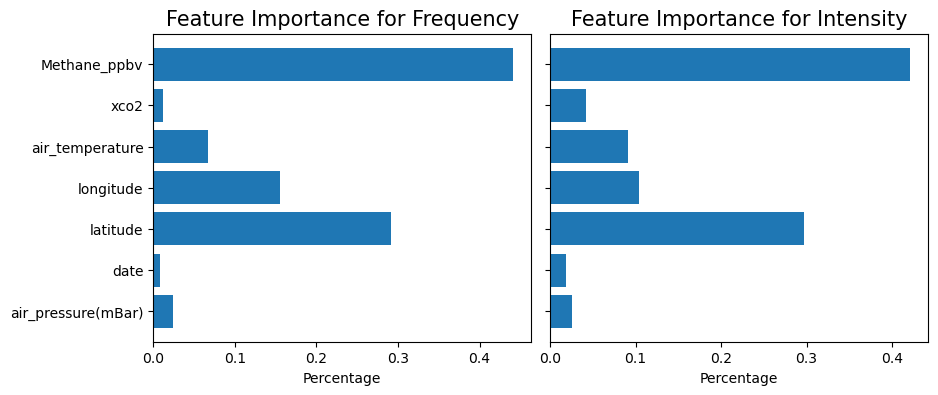

In [340]:
# plot feature importance
plt.figure(figsize = (10,8))
plt.subplots_adjust(wspace=0.05, hspace=0)
axe1  = plt.subplot(221)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Feature Importance for Frequency', fontsize = 15)
plt.xlabel('Percentage', fontsize = 10)
axe1.barh(X_test.columns, estimator.estimators_[0].feature_importances_)
plt.xticks(np.arange(0, max(estimator.estimators_[1].feature_importances_), 0.1))

axe2 = plt.subplot(222)
axe2.barh(X_test.columns, estimator.estimators_[1].feature_importances_)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Feature Importance for Intensity', fontsize = 15)
plt.xlabel('Percentage', fontsize = 10)
plt.xticks(np.arange(0, max(estimator.estimators_[1].feature_importances_), 0.1))
axe2.axes.yaxis.set_ticklabels([]);

# Random Forest

In [355]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
# 'estimator__max_depth':[1000]}
parameters = {'estimator__n_estimators': [2, 10, 100], 'estimator__criterion':['squared_error','absolute_error','friedman_mse','poisson'],'estimator__max_features':['sqrt','log2',None], 
              'estimator__max_depth':[10, 100], 'estimator__min_samples_split':[2, 10, 100]}
grid3 = GridSearchCV(MultiOutputRegressor(RandomForestRegressor ()), parameters, verbose=10, cv=5).fit(X_train.astype(int), 
                                                                                                 Y_train.astype(int))
# print best parameter after tuning 
print(grid3.best_params_) 
# grid_predictions = grid.predict(X_test) 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5; 1/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=2
[CV 1/5; 1/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=2;, score=0.969 total time=   0.0s
[CV 2/5; 1/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=2
[CV 2/5; 1/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=2;, score=0.960 total time=   0.0s
[CV 3/5; 1/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=2
[CV 3/5; 1/216] END

[CV 3/5; 5/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.974 total time=   0.2s
[CV 4/5; 5/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 4/5; 5/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.971 total time=   0.2s
[CV 5/5; 5/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 5/5; 5/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.976 total time=   0.2s
[CV 1/5; 6/216] START estimator__criterion

[CV 5/5; 9/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.968 total time=   2.6s
[CV 1/5; 10/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=2
[CV 1/5; 10/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=2;, score=0.964 total time=   0.0s
[CV 2/5; 10/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=2
[CV 2/5; 10/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=2;, score=0.961 total time=   0.0s
[CV 3/5; 10/216] START estimator__criterion=

[CV 2/5; 14/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.972 total time=   0.2s
[CV 3/5; 14/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 3/5; 14/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.977 total time=   0.2s
[CV 4/5; 14/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 4/5; 14/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.978 total time=   0.2s
[CV 5/5; 14/216] START estimator__cri

[CV 4/5; 18/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.965 total time=   2.6s
[CV 5/5; 18/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 5/5; 18/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.967 total time=   2.9s
[CV 1/5; 19/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=2
[CV 1/5; 19/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=2;, score=0.960 total time=   0.1s
[CV 2/5; 19/216] START estimator__c

[CV 1/5; 23/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.963 total time=   0.6s
[CV 2/5; 23/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 2/5; 23/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.959 total time=   0.6s
[CV 3/5; 23/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 3/5; 23/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.965 total time=   0.6s
[CV 4/5; 23/216] START estimator__cri

[CV 3/5; 27/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.950 total time=   6.9s
[CV 4/5; 27/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 4/5; 27/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.948 total time=   6.7s
[CV 5/5; 27/216] START estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 5/5; 27/216] END estimator__criterion=squared_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.949 total time=   7.1s
[CV 1/5; 28/216] START esti

[CV 1/5; 32/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.995 total time=   0.2s
[CV 2/5; 32/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 2/5; 32/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.996 total time=   0.2s
[CV 3/5; 32/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 3/5; 32/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.996 total time=   0.2s
[CV 4/5; 32/216] START estimator

[CV 3/5; 36/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.982 total time=   2.9s
[CV 4/5; 36/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 4/5; 36/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.982 total time=   2.9s
[CV 5/5; 36/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 5/5; 36/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.983 total time=   3.1s
[CV 1/5; 37/216] START

[CV 1/5; 41/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.996 total time=   0.2s
[CV 2/5; 41/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 2/5; 41/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.997 total time=   0.2s
[CV 3/5; 41/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 3/5; 41/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.995 total time=   0.2s
[CV 4/5; 41/216] START estimator

[CV 3/5; 45/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.982 total time=   2.8s
[CV 4/5; 45/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 4/5; 45/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.982 total time=   3.1s
[CV 5/5; 45/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 5/5; 45/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.982 total time=   3.2s
[CV 1/5; 46/216] START

[CV 1/5; 50/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.995 total time=   0.7s
[CV 2/5; 50/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 2/5; 50/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.996 total time=   0.7s
[CV 3/5; 50/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 3/5; 50/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.992 total time=   0.7s
[CV 4/5; 50/216] START estimator

[CV 3/5; 54/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.972 total time=   7.5s
[CV 4/5; 54/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 4/5; 54/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.971 total time=   7.4s
[CV 5/5; 54/216] START estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 5/5; 54/216] END estimator__criterion=squared_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.975 total time=   7.4s
[CV 1/5; 55/216] START

[CV 5/5; 58/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.829 total time=   2.9s
[CV 1/5; 59/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 1/5; 59/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.906 total time=  13.8s
[CV 2/5; 59/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 2/5; 59/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.903 total time=  14.2s
[CV 3/5; 59/216] START estimator_

[CV 2/5; 63/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.921 total time= 2.2min
[CV 3/5; 63/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 3/5; 63/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.924 total time= 2.3min
[CV 4/5; 63/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 4/5; 63/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.916 total time= 2.3min
[CV 5/5; 63/216] START

[CV 4/5; 67/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.860 total time=   2.8s
[CV 5/5; 67/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 5/5; 67/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.884 total time=   2.5s
[CV 1/5; 68/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 1/5; 68/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.918 total time=  13.0s
[CV 2/5; 68/216] START estimator__c

[CV 1/5; 72/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.921 total time= 2.4min
[CV 2/5; 72/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 2/5; 72/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.914 total time= 2.4min
[CV 3/5; 72/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 3/5; 72/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.919 total time= 2.5min
[CV 4/5; 72/216] START

[CV 3/5; 76/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.869 total time=   7.7s
[CV 4/5; 76/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 4/5; 76/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.927 total time=   7.4s
[CV 5/5; 76/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 5/5; 76/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.846 total time=   7.7s
[CV 1/5; 77/216] START estimator__cri

[CV 5/5; 80/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.931 total time=  36.3s
[CV 1/5; 81/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 1/5; 81/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.939 total time= 6.2min
[CV 2/5; 81/216] START estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 2/5; 81/216] END estimator__criterion=absolute_error, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.933 total time= 6.2min
[CV 3/5; 81/216] START 

[CV 2/5; 85/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.963 total time=   7.8s
[CV 3/5; 85/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 3/5; 85/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.987 total time=   7.6s
[CV 4/5; 85/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 4/5; 85/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.988 total time=   6.8s
[CV 5/5; 85/216] START estimator

[CV 4/5; 89/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.975 total time=  42.3s
[CV 5/5; 89/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 5/5; 89/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.975 total time=  39.4s
[CV 1/5; 90/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 1/5; 90/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.981 total time= 6.2min
[CV 2/5; 90/216] STA

[CV 1/5; 94/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.987 total time=   7.3s
[CV 2/5; 94/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 2/5; 94/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.989 total time=   7.3s
[CV 3/5; 94/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 3/5; 94/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.988 total time=   8.1s
[CV 4/5; 94/216] START estimator

[CV 3/5; 98/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.974 total time=  39.6s
[CV 4/5; 98/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 4/5; 98/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.970 total time=  37.7s
[CV 5/5; 98/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 5/5; 98/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.965 total time=  35.2s
[CV 1/5; 99/216] START

[CV 5/5; 102/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.996 total time=17.7min
[CV 1/5; 103/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 1/5; 103/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.984 total time=  19.7s
[CV 2/5; 103/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 2/5; 103/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.991 total time=  20.2s
[CV 3/5; 103/216] START es

[CV 2/5; 107/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.982 total time= 1.8min
[CV 3/5; 107/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 3/5; 107/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.971 total time= 1.8min
[CV 4/5; 107/216] START estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 4/5; 107/216] END estimator__criterion=absolute_error, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.972 total time= 1.7min
[CV 5/5; 107/216]

[CV 4/5; 111/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.977 total time=   2.8s
[CV 5/5; 111/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 5/5; 111/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.979 total time=   2.7s
[CV 1/5; 112/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 1/5; 112/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.972 total time=   0.0s
[CV 2/5; 112/216] START estimator__crit

[CV 1/5; 116/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.963 total time=   0.2s
[CV 2/5; 116/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 2/5; 116/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.959 total time=   0.3s
[CV 3/5; 116/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 3/5; 116/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.959 total time=   0.2s
[CV 4/5; 116/216] START estimato

[CV 3/5; 120/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.980 total time=   2.7s
[CV 4/5; 120/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 4/5; 120/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.978 total time=   2.9s
[CV 5/5; 120/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 5/5; 120/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.978 total time=   2.7s
[CV 1/5; 121/216] START estimator__cr

[CV 1/5; 125/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.963 total time=   0.2s
[CV 2/5; 125/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 2/5; 125/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.966 total time=   0.2s
[CV 3/5; 125/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 3/5; 125/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.967 total time=   0.2s
[CV 4/5; 125/216] START estimato

[CV 3/5; 129/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.963 total time=   6.5s
[CV 4/5; 129/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 4/5; 129/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.966 total time=   6.9s
[CV 5/5; 129/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 5/5; 129/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.963 total time=   6.6s
[CV 1/5; 130/216] START estimator__cr

[CV 1/5; 134/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.951 total time=   0.6s
[CV 2/5; 134/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 2/5; 134/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.942 total time=   0.6s
[CV 3/5; 134/216] START estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 3/5; 134/216] END estimator__criterion=friedman_mse, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.947 total time=   0.6s
[CV 4/5; 134/216] START estimato

[CV 3/5; 138/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.998 total time=   3.3s
[CV 4/5; 138/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 4/5; 138/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.996 total time=   3.0s
[CV 5/5; 138/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 5/5; 138/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.997 total time=   3.0s
[CV 1/5; 139/216] START estimato

[CV 1/5; 143/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.979 total time=   0.2s
[CV 2/5; 143/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 2/5; 143/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.978 total time=   0.2s
[CV 3/5; 143/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 3/5; 143/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.979 total time=   0.2s
[CV 4/5; 143/216] START est

[CV 3/5; 147/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.998 total time=   3.0s
[CV 4/5; 147/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 4/5; 147/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.997 total time=   3.0s
[CV 5/5; 147/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 5/5; 147/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.997 total time=   3.0s
[CV 1/5; 148/216] START estimato

[CV 1/5; 152/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.979 total time=   0.2s
[CV 2/5; 152/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 2/5; 152/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.980 total time=   0.2s
[CV 3/5; 152/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 3/5; 152/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.978 total time=   0.3s
[CV 4/5; 152/216] START est

[CV 3/5; 156/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.994 total time=   7.5s
[CV 4/5; 156/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 4/5; 156/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.995 total time=   7.7s
[CV 5/5; 156/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 5/5; 156/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.996 total time=   7.4s
[CV 1/5; 157/216] START estimato

[CV 1/5; 161/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.970 total time=   0.7s
[CV 2/5; 161/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 2/5; 161/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.971 total time=   0.7s
[CV 3/5; 161/216] START estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 3/5; 161/216] END estimator__criterion=friedman_mse, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.974 total time=   0.7s
[CV 4/5; 161/216] START est

[CV 3/5; 165/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.618 total time=   4.3s
[CV 4/5; 165/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 4/5; 165/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.634 total time=   4.0s
[CV 5/5; 165/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 5/5; 165/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.626 total time=   4.0s
[CV 1/5; 166/216] START estimator__criterion=poisson, estimato

[CV 1/5; 170/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.588 total time=   0.4s
[CV 2/5; 170/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 2/5; 170/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.607 total time=   0.3s
[CV 3/5; 170/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 3/5; 170/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.561 total time=   0.3s
[CV 4/5; 170/216] START estimator__criterion=poisson, est

[CV 4/5; 174/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.620 total time=   4.0s
[CV 5/5; 174/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100
[CV 5/5; 174/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.629 total time=   4.2s
[CV 1/5; 175/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 1/5; 175/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.547 total time=   0.0s
[CV 2/5; 175/216] START estimator__criterion=poisson, estimator_

[CV 2/5; 179/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.582 total time=   0.3s
[CV 3/5; 179/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 3/5; 179/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.602 total time=   0.3s
[CV 4/5; 179/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 4/5; 179/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.609 total time=   0.3s
[CV 5/5; 179/216] START estimator__criterion=poisson, est

[CV 5/5; 183/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=2, estimator__n_estimators=100;, score=0.442 total time=  10.6s
[CV 1/5; 184/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 1/5; 184/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.444 total time=   0.1s
[CV 2/5; 184/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 2/5; 184/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.405 total time=   0.1s
[CV 3/5; 184/216] START estimator__criterion=poisson, estimator__m

[CV 3/5; 188/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.444 total time=   1.0s
[CV 4/5; 188/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 4/5; 188/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.429 total time=   1.0s
[CV 5/5; 188/216] START estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10
[CV 5/5; 188/216] END estimator__criterion=poisson, estimator__max_depth=10, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.452 total time=   1.0s
[CV 1/5; 189/216] START estimator__criterion=poisson, est

[CV 2/5; 193/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.888 total time=   0.1s
[CV 3/5; 193/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 3/5; 193/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.892 total time=   0.1s
[CV 4/5; 193/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 4/5; 193/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.878 total time=   0.1s
[CV 5/5; 193/216] START estimator__criterion=poisson, estimato

[CV 5/5; 197/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=10;, score=0.885 total time=   0.7s
[CV 1/5; 198/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 1/5; 198/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.889 total time=   7.8s
[CV 2/5; 198/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 2/5; 198/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.879 total time=   7.8s
[CV 3/5; 198/216] START estimator__criterion=poi

[CV 4/5; 202/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.883 total time=   0.1s
[CV 5/5; 202/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2
[CV 5/5; 202/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.890 total time=   0.1s
[CV 1/5; 203/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 1/5; 203/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.918 total time=   0.7s
[CV 2/5; 203/216] START estimator__criterion=poisson, estima

[CV 2/5; 207/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.878 total time=   7.9s
[CV 3/5; 207/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 3/5; 207/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.889 total time=   7.6s
[CV 4/5; 207/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 4/5; 207/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=log2, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.887 total time=   7.7s
[CV 5/5; 207/216] START estimator__criterion=po

[CV 5/5; 211/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=2;, score=0.606 total time=   1.3s
[CV 1/5; 212/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 1/5; 212/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.617 total time=   6.5s
[CV 2/5; 212/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10
[CV 2/5; 212/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=10, estimator__n_estimators=10;, score=0.616 total time=   6.4s
[CV 3/5; 212/216] START estimator__criterion=poisson, esti

[CV 3/5; 216/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.598 total time=  30.1s
[CV 4/5; 216/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 4/5; 216/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.583 total time=  27.3s
[CV 5/5; 216/216] START estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100
[CV 5/5; 216/216] END estimator__criterion=poisson, estimator__max_depth=100, estimator__max_features=None, estimator__min_samples_split=100, estimator__n_estimators=100;, score=0.592 total time=  27.7s
{'estimator__criterion': 'squared_error', 'esti

In [356]:
print(grid3.best_params_) 

{'estimator__criterion': 'squared_error', 'estimator__max_depth': 100, 'estimator__max_features': 'log2', 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}


In [680]:
%%time
params = {'n_estimators': 100, 'max_depth': 100, 'max_features':'log2',
          'min_samples_split': 2, 'min_samples_split':2,'criterion': 'squared_error'}
# estimator_rf = MultiOutputRegressor(ensemble.RandomForestClassifier(params)).fit(X_train, Y_train)
estimator_rf = MultiOutputRegressor(ensemble.RandomForestRegressor (**params)).fit(X_train, Y_train)

Y_predicted_rf = estimator_rf.predict(X_test)

total_train = Y_test.shape[0]
Y_1_true = np.array(Y_test['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted_rf]))
Y_2_true = np.array(Y_test['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])

correct_train_intensity = 0
for index, value in enumerate(Y_2_pred):
    if np.round(value) == Y_2_true[index]:
        correct_train_intensity += 1
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_test_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_test_intensity = ', accuracy_test_intensity)

accuracy_test_frequency =  tensor(100.)
accuracy_test_intensity =  4.642494069806845
Wall time: 4.19 s


In [681]:
%%time
# params = {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'learning_rate':0.01}
# estimator = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params)).fit(X_train, Y_train)

Y_predicted = estimator_rf.predict(X_unseen_nn)

Y_1_true = np.array(Y_unseen_nn['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted]))
Y_2_true = np.array(Y_unseen_nn['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_unseen_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_unseen_intensity = ', accuracy_test_intensity)

accuracy_unseen_frequency =  tensor(0.)
accuracy_unseen_intensity =  4.642494069806845
Wall time: 28.3 ms


In [682]:
import pickle
pickle.dump(estimator_rf, open(current_dir + r'\Models\RandomForest\model1', 'wb'))

In [683]:
%%time
params = {'n_estimators': 100, 'max_depth': 100, 'max_features':'log2',
          'min_samples_split': 2, 'min_samples_split':2,'criterion': 'squared_error'}
# estimator_rf = MultiOutputRegressor(ensemble.RandomForestClassifier(params)).fit(X_train, Y_train)
estimator_rf = MultiOutputRegressor(ensemble.RandomForestRegressor (**params)).fit(X_train, Y_train)

Y_predicted_rf = estimator_rf.predict(X_test)

total_train = Y_test.shape[0]
Y_1_true = np.array(Y_test['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted_rf]))
Y_2_true = np.array(Y_test['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])

correct_train_intensity = 0
for index, value in enumerate(Y_2_pred):
    if np.round(value) == Y_2_true[index]:
        correct_train_intensity += 1
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_test_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_test_intensity = ', accuracy_test_intensity)

accuracy_test_frequency =  tensor(100.)
accuracy_test_intensity =  5.760759064723822
Wall time: 4.26 s


In [684]:
%%time
# params = {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'learning_rate':0.01}
# estimator = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params)).fit(X_train, Y_train)

Y_predicted = estimator_rf.predict(X_unseen_nn)

Y_1_true = np.array(Y_unseen_nn['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted]))
Y_2_true = np.array(Y_unseen_nn['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_unseen_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_unseen_intensity = ', accuracy_test_intensity)

accuracy_unseen_frequency =  tensor(0.)
accuracy_unseen_intensity =  5.760759064723822
Wall time: 24 ms


In [685]:
import pickle
pickle.dump(estimator_rf, open(current_dir + r'\Models\RandomForest\model2', 'wb'))

In [686]:
%%time
params = {'n_estimators': 100, 'max_depth': 100, 'max_features':'log2',
          'min_samples_split': 2, 'min_samples_split':2,'criterion': 'squared_error'}
# estimator_rf = MultiOutputRegressor(ensemble.RandomForestClassifier(params)).fit(X_train, Y_train)
estimator_rf = MultiOutputRegressor(ensemble.RandomForestRegressor (**params)).fit(X_train, Y_train)

Y_predicted_rf = estimator_rf.predict(X_test)

total_train = Y_test.shape[0]
Y_1_true = np.array(Y_test['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted_rf]))
Y_2_true = np.array(Y_test['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])

correct_train_intensity = 0
for index, value in enumerate(Y_2_pred):
    if np.round(value) == Y_2_true[index]:
        correct_train_intensity += 1
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_test_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_test_intensity = ', accuracy_test_intensity)

accuracy_test_frequency =  tensor(99.9664)
accuracy_test_intensity =  5.726872246696035
Wall time: 4.39 s


In [687]:
%%time
# params = {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'learning_rate':0.01}
# estimator = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params)).fit(X_train, Y_train)

Y_predicted = estimator_rf.predict(X_unseen_nn)

Y_1_true = np.array(Y_unseen_nn['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted]))
Y_2_true = np.array(Y_unseen_nn['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_unseen_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_unseen_intensity = ', accuracy_test_intensity)

accuracy_unseen_frequency =  tensor(0.)
accuracy_unseen_intensity =  5.726872246696035
Wall time: 24 ms


In [688]:
import pickle
pickle.dump(estimator_rf, open(current_dir + r'\Models\RandomForest\model3', 'wb'))

In [689]:
%%time
params = {'n_estimators': 100, 'max_depth': 100, 'max_features':'log2',
          'min_samples_split': 2, 'min_samples_split':2,'criterion': 'squared_error'}
# estimator_rf = MultiOutputRegressor(ensemble.RandomForestClassifier(params)).fit(X_train, Y_train)
estimator_rf = MultiOutputRegressor(ensemble.RandomForestRegressor (**params)).fit(X_train, Y_train)

Y_predicted_rf = estimator_rf.predict(X_test)

total_train = Y_test.shape[0]
Y_1_true = np.array(Y_test['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted_rf]))
Y_2_true = np.array(Y_test['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])

correct_train_intensity = 0
for index, value in enumerate(Y_2_pred):
    if np.round(value) == Y_2_true[index]:
        correct_train_intensity += 1
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_test_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_test_intensity = ', accuracy_test_intensity)

accuracy_test_frequency =  tensor(100.)
accuracy_test_intensity =  4.710267705862419
Wall time: 4.19 s


In [690]:
%%time
# params = {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'learning_rate':0.01}
# estimator = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params)).fit(X_train, Y_train)

Y_predicted = estimator_rf.predict(X_unseen_nn)

Y_1_true = np.array(Y_unseen_nn['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted]))
Y_2_true = np.array(Y_unseen_nn['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_unseen_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_unseen_intensity = ', accuracy_test_intensity)

accuracy_unseen_frequency =  tensor(0.)
accuracy_unseen_intensity =  4.710267705862419
Wall time: 27.6 ms


In [691]:
import pickle
pickle.dump(estimator_rf, open(current_dir + r'\Models\RandomForest\model4', 'wb'))

In [692]:
%%time
params = {'n_estimators': 100, 'max_depth': 100, 'max_features':'log2',
          'min_samples_split': 2, 'min_samples_split':2,'criterion': 'squared_error'}
# estimator_rf = MultiOutputRegressor(ensemble.RandomForestClassifier(params)).fit(X_train, Y_train)
estimator_rf = MultiOutputRegressor(ensemble.RandomForestRegressor (**params)).fit(X_train, Y_train)

Y_predicted_rf = estimator_rf.predict(X_test)

total_train = Y_test.shape[0]
Y_1_true = np.array(Y_test['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted_rf]))
Y_2_true = np.array(Y_test['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])

correct_train_intensity = 0
for index, value in enumerate(Y_2_pred):
    if np.round(value) == Y_2_true[index]:
        correct_train_intensity += 1
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_test_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_test_intensity = ', accuracy_test_intensity)

accuracy_test_frequency =  tensor(100.)
accuracy_test_intensity =  1.5757370382921043
Wall time: 4.29 s


In [693]:
%%time
# params = {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'learning_rate':0.01}
# estimator = MultiOutputRegressor(ensemble.GradientBoostingRegressor(**params)).fit(X_train, Y_train)

Y_predicted = estimator_rf.predict(X_unseen_nn)

Y_1_true = np.array(Y_unseen_nn['tropical_storm_occurence'])
Y_1_pred = np.round(np.array([item[0] for item in Y_predicted]))
Y_2_true = np.array(Y_unseen_nn['USA_SSHS'])
Y_2_pred = np.array([item[1] for item in Y_predicted])
        
metric = BinaryPrecision()
accuracy_test_freq = 100 * metric(torch.Tensor(Y_1_pred), torch.Tensor(Y_1_true))
print('accuracy_unseen_frequency = ', accuracy_test_freq)
accuracy_test_intensity = 100 * correct_train_intensity/total_train
print('accuracy_unseen_intensity = ', accuracy_test_intensity)

accuracy_unseen_frequency =  tensor(0.)
accuracy_unseen_intensity =  1.5757370382921043
Wall time: 24.3 ms


In [694]:
import pickle
pickle.dump(estimator_rf, open(current_dir + r'\Models\RandomForest\model5', 'wb'))

# ENSEMBLE MODEL

In [695]:
# CNN_LSTM_DECODER
class SoftOrdering1DCNN(pl.LightningModule):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2, LSTM_option = False):
        super().__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        self.loss = nn.BCEWithLogitsLoss()

        self.first_dense = FirstDense(input_dim, dropout_input, sign_size, cha_input)
        self.first_and_second_conv = First_and_Second_Conv(cha_input, K, sign_size, dropout_hidden, cha_hidden)
        self.third_and_fourth_conv = Third_and_Fourth_Conv(cha_hidden, dropout_hidden)
        self.flatten_batchNorm_dropout = Flatten_BatchNorm_Dropout(sign_size, cha_hidden, dropout_output)
        self.x1_output = X1_Output(sign_size, cha_hidden, output_dim)
        self.x2_output = X2_Output(sign_size, cha_hidden, output_dim)
        
        self.LSTM_option = LSTM_option
        self.lstm1 = nn.LSTMCell(256, 256)
        self.lstm2 = nn.LSTMCell(256, 256)
        
    def forward(self, x):
        x = self.first_dense(x)
        x = self.first_and_second_conv(x)
        x_s = x
        x = self.third_and_fourth_conv(x)

        x = self.flatten_batchNorm_dropout(x, x_s)
        
        if self.LSTM_option:
            x, _ = self.lstm1(x)

        x1 = self.x1_output(x)
        x2 = self.x2_output(x)
        
        return x1, x2
CNN_LSTM_decoder = SoftOrdering1DCNN(input_dim=7, output_dim=1, sign_size=16, cha_input=32, 
                                     cha_hidden=64, K=2, dropout_input = 0.3, 
                                     dropout_hidden = 0.3, dropout_output = 0.2, 
                                     LSTM_option = True)
CNN_LSTM_decoder.load_state_dict(torch.load(current_dir + r'\Models\LSTM_Decoder\LSTM_model1'))


# CNN_LSTM_PINN
CNN_LSTM_PINN = SoftOrdering1DCNN_LSTM(input_dim=7, output_dim=1, sign_size=16, cha_input=32, 
                                       cha_hidden=64, K=2, dropout_input = 0.3, 
                                       dropout_hidden = 0.3, dropout_output = 0.2, 
                                       LSTM_option = False, LSTM_separate = True)
CNN_LSTM_PINN.load_state_dict(torch.load(current_dir + r'\Models\CNN_LSTM_PINN\model1'))

# XGBoost
XGBoost = pickle.load(open(current_dir + r'\Models\XGBoost\model1', 'rb'))

In [697]:
data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956
X_xg = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_xg = data_nn['tropical_storm_occurence'].values
X_xg, Y_xg = SMOTE().fit_resample(X_xg, Y_xg)
data_xg = pd.DataFrame(np.column_stack([X_xg,Y_xg]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_xg = data_xg[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']]
Y_xg = data_xg[['tropical_storm_occurence','USA_SSHS']]

X_train, X_test, Y_train, Y_test = train_test_split(X_xg, Y_xg, test_size = 0.2, random_state = 42) 

data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']]
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']]

In [698]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in test_loader_nn:
    unseen_freq_pred1, unseen_intensity_pred1 = CNN_LSTM_decoder(unseenpred)
    unseen_freq_pred2, unseen_intensity_pred2 = CNN_LSTM_PINN(unseenpred)
    X_test = pd.DataFrame(unseenpred, columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']) # Return as dataframe
    unseen_freq_pred3 = torch.from_numpy(XGBoost.predict(X_test))[:,0].unsqueeze(dim=1)
    unseen_intensity_pred3 = torch.from_numpy(XGBoost.predict(X_test))[:,1].unsqueeze(dim=1)
    
    combined_preds_freq = torch.cat([unseen_freq_pred1, unseen_freq_pred2, unseen_freq_pred3], 1)
    combined_preds_intensity = torch.cat([unseen_intensity_pred1, unseen_intensity_pred2, unseen_intensity_pred3], 1)
    
    unseen_freq_pred = torch.mean(combined_preds_freq, 1).unsqueeze(dim=1)
    unseen_intensity_pred = torch.mean(combined_preds_intensity,1).unsqueeze(dim=1)
    
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
            
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = torch.round(100*metric(torch.round(unseen_freq_pred), unseen_freq))
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity test = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq test = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity test =  51.076088
accuracy freq test =  99.71739


In [699]:
accuracy_list_unseen_freq = []
accuracy_list_unseen_intensity = []
for unseenpred, unseentarget in unseen_nn:
    unseen_freq_pred1, unseen_intensity_pred1 = CNN_LSTM_decoder(unseenpred)
    unseen_freq_pred2, unseen_intensity_pred2 = CNN_LSTM_PINN(unseenpred)
    X_test = pd.DataFrame(unseenpred, columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']) # Return as dataframe
    unseen_freq_pred3 = torch.from_numpy(XGBoost.predict(X_test))[:,0].unsqueeze(dim=1)
    unseen_intensity_pred3 = torch.from_numpy(XGBoost.predict(X_test))[:,1].unsqueeze(dim=1)
    
    combined_preds_freq = torch.cat([unseen_freq_pred1, unseen_freq_pred2, unseen_freq_pred3], 1)
    combined_preds_intensity = torch.cat([unseen_intensity_pred1, unseen_intensity_pred2, unseen_intensity_pred3], 1)
    
    unseen_freq_pred = torch.mean(combined_preds_freq, 1).unsqueeze(dim=1)
    unseen_intensity_pred = torch.mean(combined_preds_intensity,1).unsqueeze(dim=1)
    
    unseen_freq = torch.Tensor([item[0] for item in unseentarget]).unsqueeze(1)
    unseen_intensity = torch.Tensor([item[1] for item in unseentarget]).unsqueeze(1)
            
    total_unseen = unseen_freq.size(0)
    correct_unseen_intensity = (torch.round(unseen_intensity_pred) == unseen_intensity).sum()
    accuracy_unseen_freq = torch.round(100*metric(torch.round(unseen_freq_pred), unseen_freq))
    accuracy_unseen_intensity = torch.round(100 * correct_unseen_intensity/total_unseen)
            
    accuracy_list_unseen_freq.append(accuracy_unseen_freq)
    accuracy_list_unseen_intensity.append(accuracy_unseen_intensity)

print('accuracy intensity test = ', np.mean(accuracy_list_unseen_intensity))
print('accuracy freq test = ', np.mean(accuracy_list_unseen_freq))

accuracy intensity test =  96.5
accuracy freq test =  0.0


# see what models learn

In [611]:
from sklearn import ensemble
from sklearn.multioutput import MultiOutputRegressor

data_code = data_code.apply(pd.to_numeric)
data_nn = data_code.copy()

# SMOTE: to account for the lack of data  #https://towaardsdatascience.com/credit-card-fraud-detection-9bc8db79b956
X_xg = data_nn[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS']].values
Y_xg = data_nn['tropical_storm_occurence'].values
X_xg, Y_xg = SMOTE().fit_resample(X_xg, Y_xg)
data_xg = pd.DataFrame(np.column_stack([X_xg,Y_xg]), columns = ['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv', 'USA_SSHS','tropical_storm_occurence']) # Return as dataframe

# split dataset
X_xg = data_xg[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']]
Y_xg = data_xg[['tropical_storm_occurence','USA_SSHS']]

X_train, X_test, Y_train, Y_test = train_test_split(X_xg, Y_xg, test_size = 0.2, random_state = 42) 

data_unseen = data_unseen.apply(pd.to_numeric)
data_unseen_nn = data_unseen.copy()

X_unseen_nn = data_unseen[['air_pressure(mBar)','date','latitude','longitude','air_temperature','xco2','Methane_ppbv']]
Y_unseen_nn = data_unseen[['tropical_storm_occurence','USA_SSHS']]

In [618]:
# test set
Y_predicted = XGBoost.predict(X_test)
Y_1test_true = np.array(Y_test['tropical_storm_occurence'])
Y_1test_pred = np.round(np.array([item[0] for item in Y_predicted]))
Y_2test_true = np.array(Y_test['USA_SSHS'])
Y_2test_pred = np.array([item[1] for item in Y_predicted])

# unseen set
Y_predicted = XGBoost.predict(X_unseen_nn)
Y_1unseen_true = np.array(Y_unseen_nn['tropical_storm_occurence'])
Y_1unseen_pred = np.array([item[0] for item in Y_predicted])
Y_2unseen_true = np.array(Y_unseen_nn['USA_SSHS'])
Y_2unseen_pred = np.array([item[1] for item in Y_predicted])

In [619]:
Y_1test_true

array([0., 1., 1., ..., 1., 1., 0.])

In [620]:
Y_1test_pred

array([0., 1., 1., ..., 1., 1., 0.])

In [621]:
from sklearn.metrics import confusion_matrix
# for test set

confusion_matrix(Y_1test_true, Y_1test_pred)

array([[2917,    7],
       [   5, 2973]], dtype=int64)

In [610]:
# for unseen set
confusion_matrix(y_true, y_pred)

NameError: name 'y_true' is not defined